In [29]:
import cv2
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.metrics
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.src.layers import Conv2DTranspose
from keras.src.losses import losses
import os

In [30]:
def evaluate_segmentation(y_true, y_pred, threshold=0.5):   
    # Calculate intersection and union
    intersection = np.sum(y_true * y_pred) // 2
    sum_y_true = np.sum(y_true)
    sum_y_pred = np.sum(y_pred)
    
    # Dice coefficient with small epsilon to avoid division by zero
    dice = (2 * intersection) / (sum_y_true + sum_y_pred + 1e-7)
    return dice

In [31]:
class Ellipse:
    def __init__(self, image_size=256, short_axis_min=100, long_axis_min=250, noise_diameter_max=30):
        self.image_size = image_size
        self.short_axis_min = short_axis_min
        self.long_axis_min = long_axis_min
        self.noise_diameter_max = noise_diameter_max
        
        self.ellipse, self.noisy_ellipse = self.generate_ellipse_with_noise()
    
    def generate_ellipse_with_noise(self):
        image = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        
        center = (self.image_size // 2, self.image_size // 2)
        short_axis = random.randint(self.short_axis_min // 2, self.image_size // 2)
        long_axis = min(random.randint(self.long_axis_min, self.image_size), short_axis * 3)
        
        ellipse_image = cv2.ellipse(image.copy(), center, (long_axis, short_axis), 0, 0, 360, 1, -1)
        
        noisy_image = self.add_noise(ellipse_image)
        
        return ellipse_image, noisy_image
    
    def add_noise(self, image):
        noisy_image = image.copy()
        
        num_noises = random.randint(5, 15)
        
        for _ in range(num_noises):
            x = random.randint(0, self.image_size - 1)
            y = random.randint(0, self.image_size - 1)
            diameter = random.randint(5, self.noise_diameter_max)
            
            cv2.circle(noisy_image, (x, y), diameter // 2, 0, -1)
            
        return noisy_image

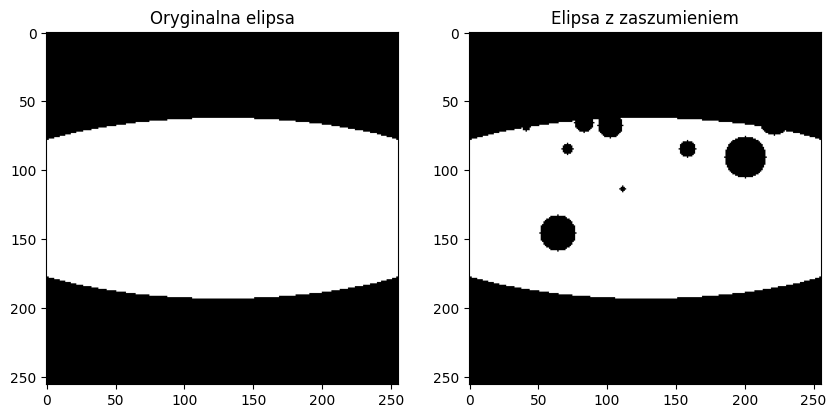

In [32]:
ellipse = Ellipse()

# Wyświetlanie obrazów oryginalnego i zaszumionego
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Oryginalna elipsa")
plt.imshow(ellipse.ellipse, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Elipsa z zaszumieniem")
plt.imshow(ellipse.noisy_ellipse, cmap='gray')
plt.show()

In [33]:
class EllipseDataset:
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples
        self.ellipses = []
        self.noisy_ellipses = []
        
        for _ in range(num_samples):
            ellipse = Ellipse()
            self.ellipses.append(ellipse.ellipse)
            self.noisy_ellipses.append(ellipse.noisy_ellipse)
            
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.ellipses[idx]
    
    def save_to_bmp(self, path):
        # Create the directories if they don't exist
        ellipse_dir = os.path.join(path, "ellipses")
        noisy_ellipse_dir = os.path.join(path, "noisy_ellipses")
        
        os.makedirs(ellipse_dir, exist_ok=True)
        os.makedirs(noisy_ellipse_dir, exist_ok=True)
        
        # Save ellipses
        for i, ellipse in enumerate(self.ellipses):
            cv2.imwrite(os.path.join(ellipse_dir, f"ellipse_{i}.bmp"), ellipse)
            
        # Save noisy ellipses
        for i, noisy_ellipse in enumerate(self.noisy_ellipses):
            cv2.imwrite(os.path.join(noisy_ellipse_dir, f"noisy_ellipse_{i}.bmp"), noisy_ellipse)

In [34]:
dataset = EllipseDataset(1000)

@keras.saving.register_keras_serializable()
class Autoencoder(Model):
    def __init__(self, input_shape=(256, 256, 1)):
        self.input_shape_ = input_shape
        super(Autoencoder, self).__init__()
        # Encoder
        self.input_img = Input(shape=input_shape)
        self.encoder = keras.Sequential([
            Input(shape=input_shape),
            Conv2D(128, (5, 5), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(32, (5, 5), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same')
        ])
    
        # Decoder
        self.decoder = keras.Sequential([
            Conv2DTranspose(32, (5, 5), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2DTranspose(128, (5, 5), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    def get_config(self):
        # Configuration dictionary for saving the model
        return {"input_shape": self.input_shape_}

    @classmethod
    def from_config(cls, config):
        # Reconstruct the model from its configuration
        return cls(**config)

autoencoder = Autoencoder()

optimizer = keras.optimizers.Adam(learning_rate=0.0005)
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()])

autoencoder.summary()

Model: "autoencoder_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_36 (Sequential)      │ (None, 64, 64, 32)     │       105,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_37 (Sequential)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,760 (413.12 KB)

 Trainable params: 105,760 (413.12 KB)

 Non-trainable params: 0 (0.00 B)

# --- Run all above before testing ---


In [35]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="checkpoints/model_at_epoch_{epoch}.keras", save_best_only=True, save_weights_only=False),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="mean_squared_error", patience=5, mode="min", restore_best_weights=True)
]

history = autoencoder.fit(x= np.array(dataset.noisy_ellipses).reshape(-1, 256, 256, 1), y= np.array(dataset.ellipses).reshape(-1, 256, 256, 1), epochs=100, batch_size=64, callbacks=callbacks, validation_split=0.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.1725 - mean_squared_error: 0.1725 - val_loss: 0.0722 - val_mean_squared_error: 0.0722
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0019 - va

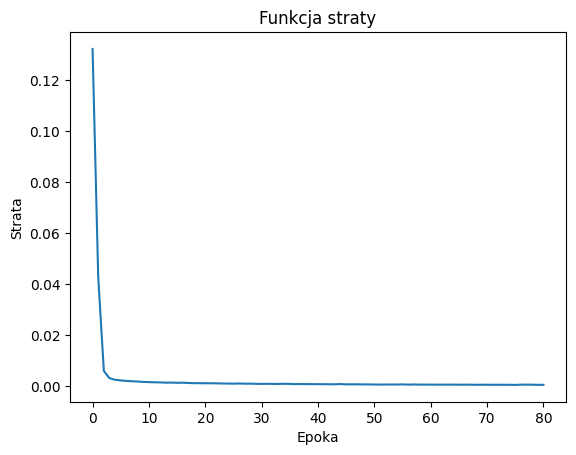

In [36]:
#save model
autoencoder.save_weights("autoencoder_weights.weights.h5")

plt.plot(history.history['loss'])
plt.title('Funkcja straty')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


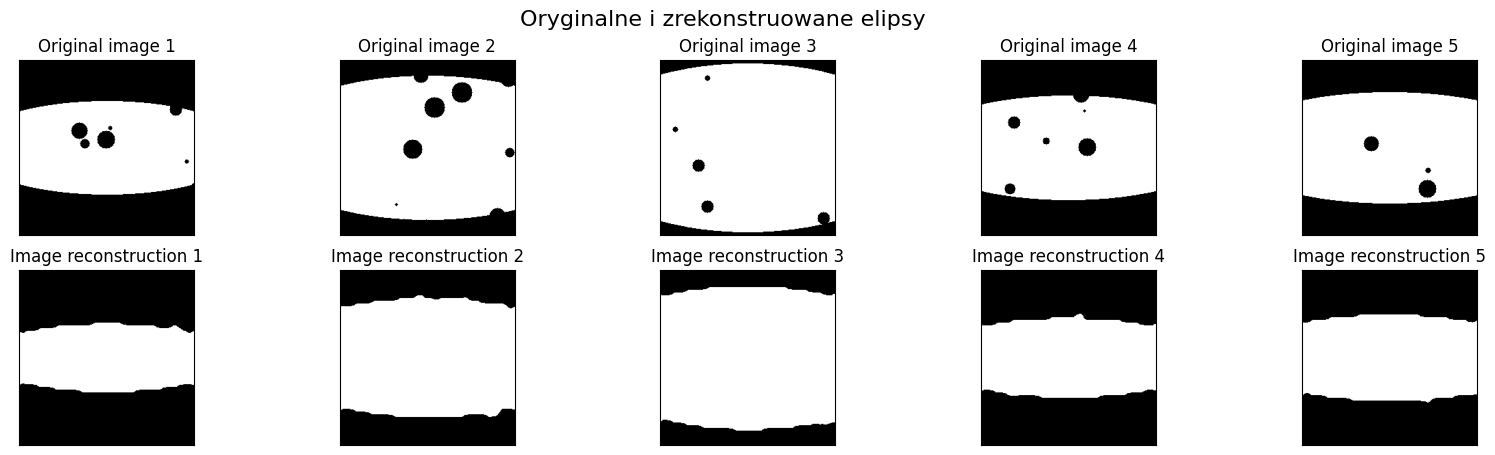

In [37]:
def plot_results(images, title, n_images=5):
    plt.figure(figsize=(20, 5))
    plt.suptitle(title, fontsize=16)
    
    for i in range(n_images):
        # Display original images
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        ax.set_title(f"Original image {i + 1}")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    for i in range(n_images):
        # Display reconstructed images
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        image = autoencoder_.predict(images[i].reshape(1, 256, 256, 1)).reshape(256, 256)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        image = cv2.medianBlur(image, 5)
        _, image = cv2.threshold(image, 205, 255, cv2.THRESH_BINARY)
        plt.imshow(image, cmap='gray')
        ax.set_title(f"Image reconstruction {i + 1}")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()
    
    
plot_results(np.array(dataset.noisy_ellipses), "Oryginalne i zrekonstruowane elipsy")

In [38]:
#check keras version
keras.__version__

'3.7.0'

# Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


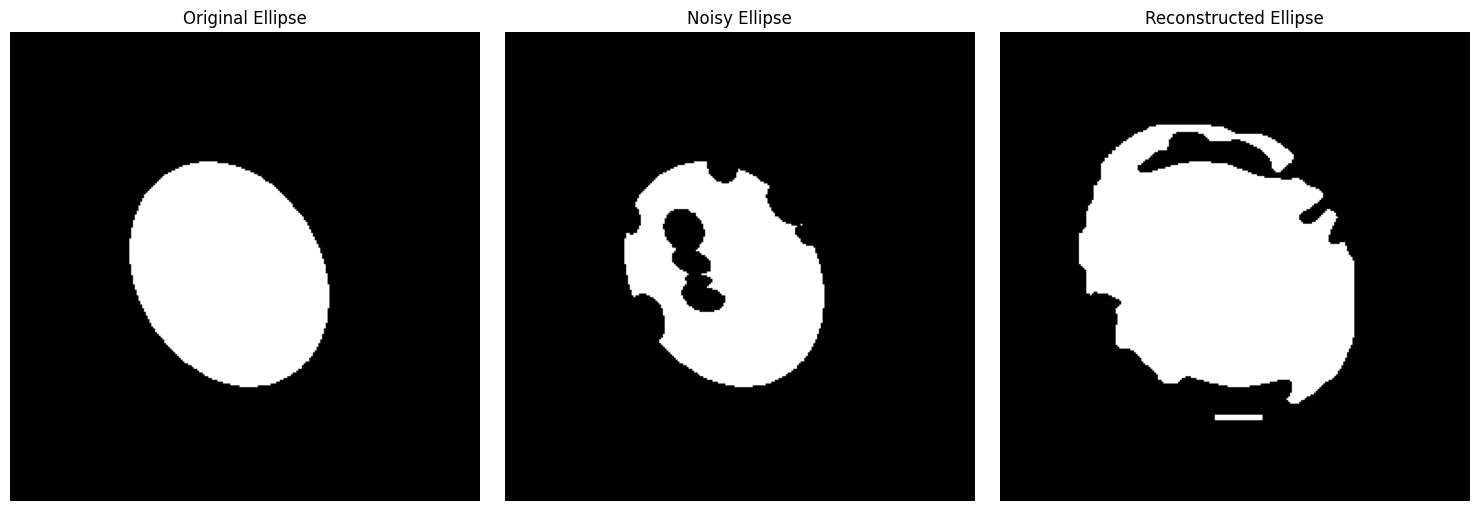

Image 1: Dice coefficient: 0.889212290832577
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


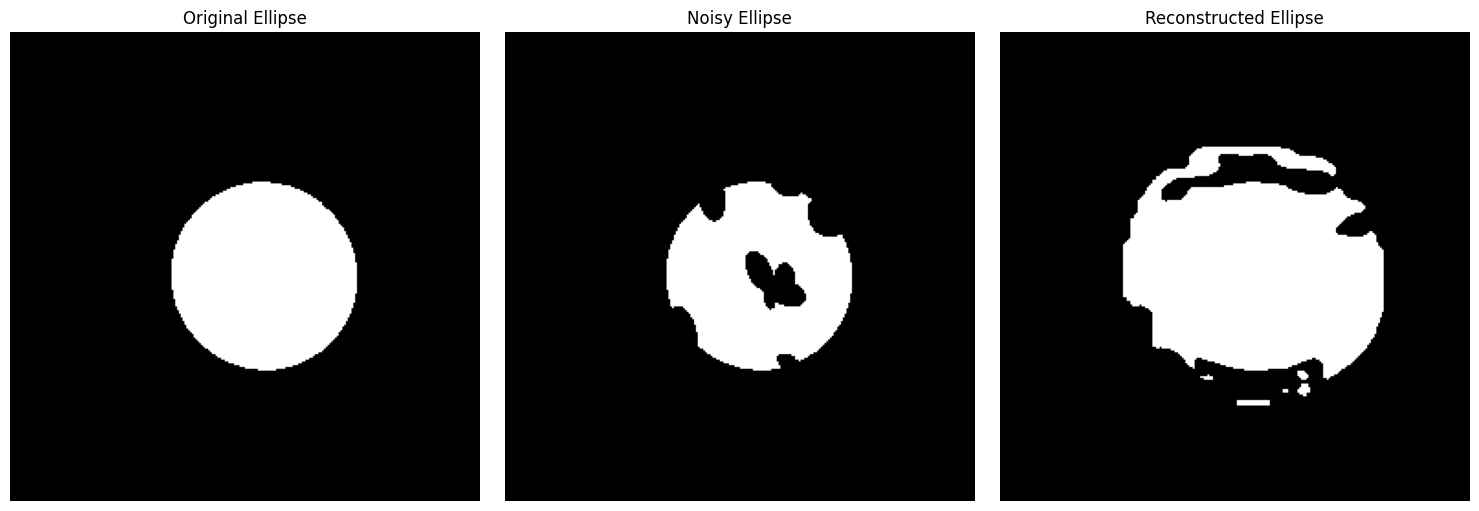

Image 2: Dice coefficient: 0.8920034768222553
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


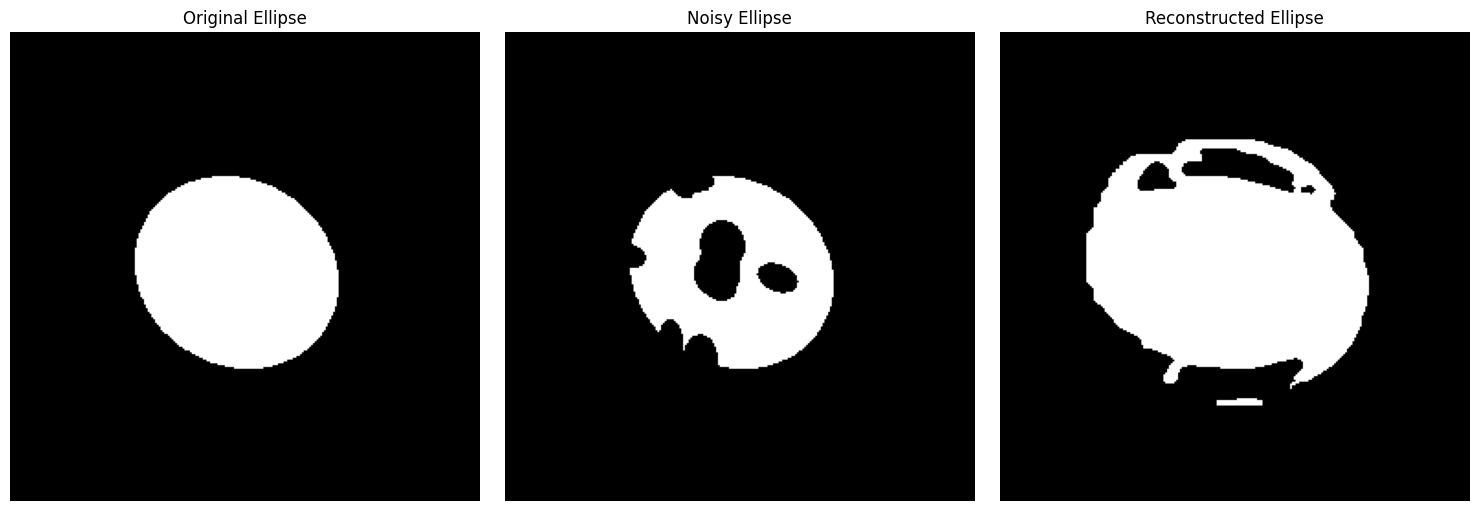

Image 3: Dice coefficient: 0.882972298308091
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


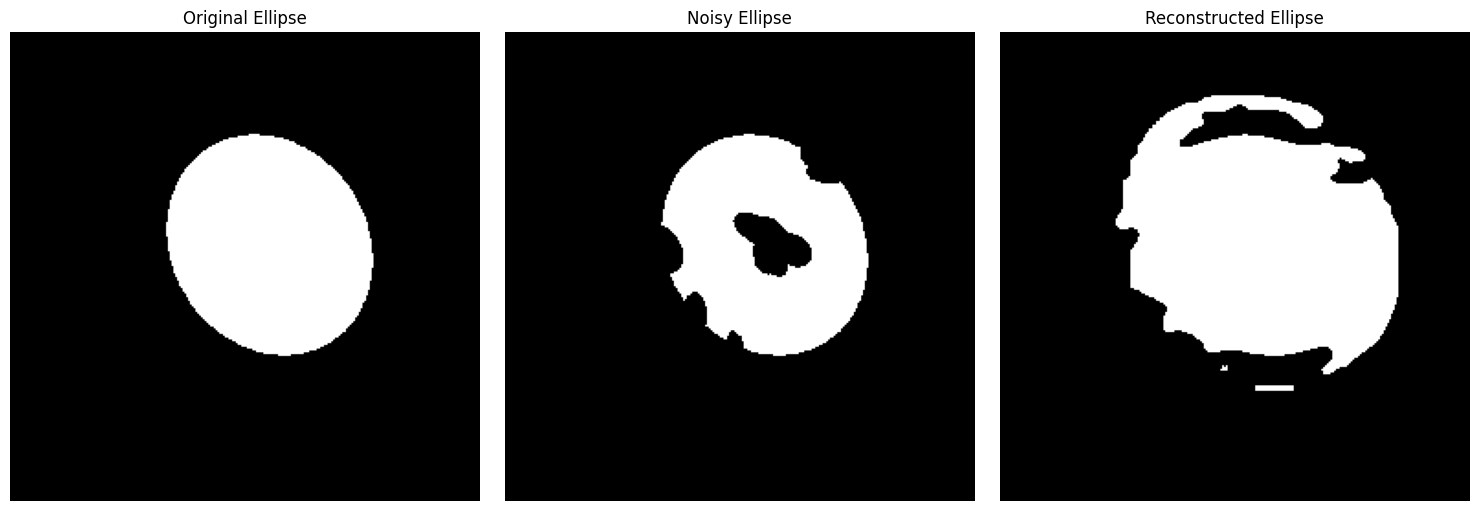

Image 4: Dice coefficient: 0.8932824603756842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


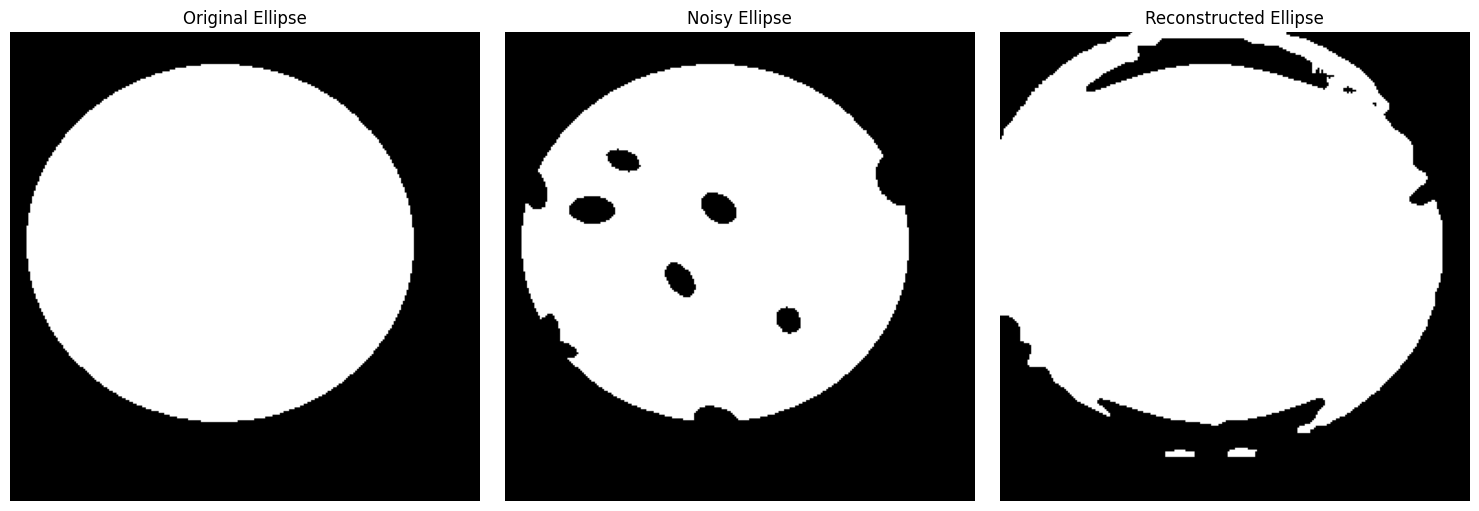

Image 5: Dice coefficient: 0.9189748732875324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


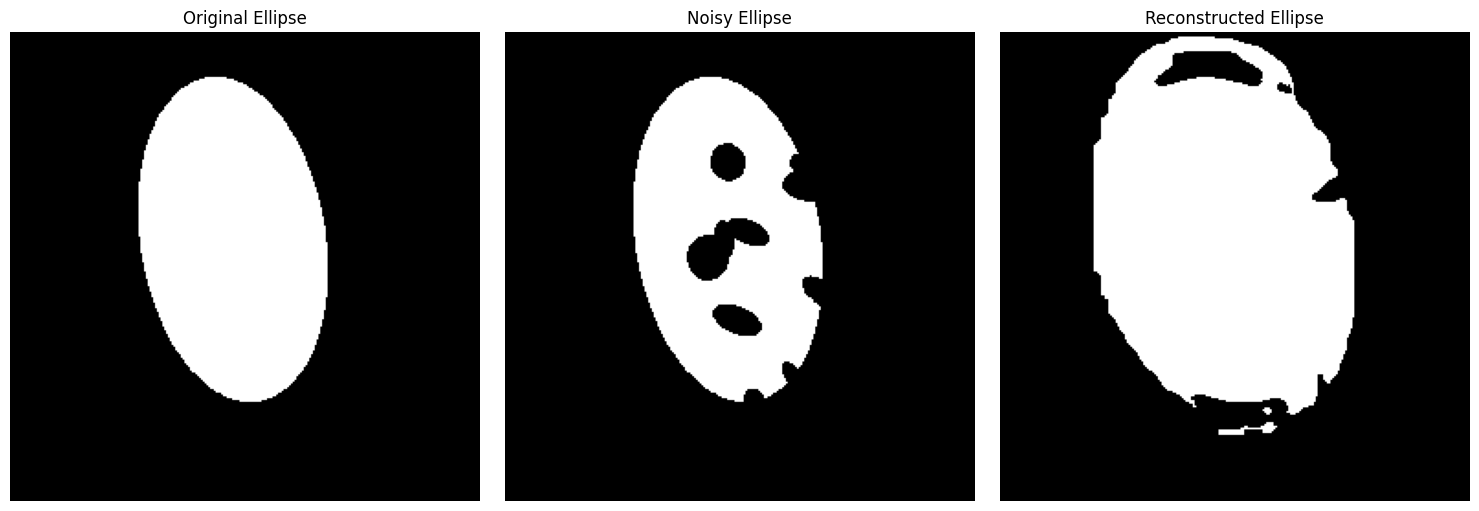

Image 6: Dice coefficient: 0.8885228741478739
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


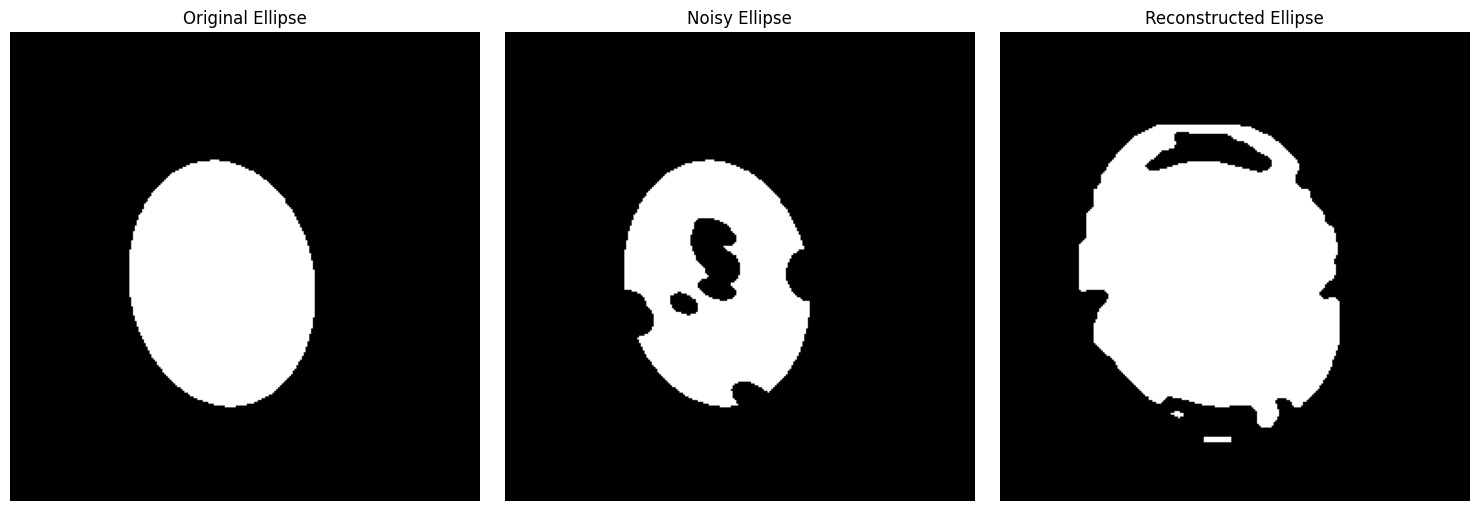

Image 7: Dice coefficient: 0.8854526392087663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


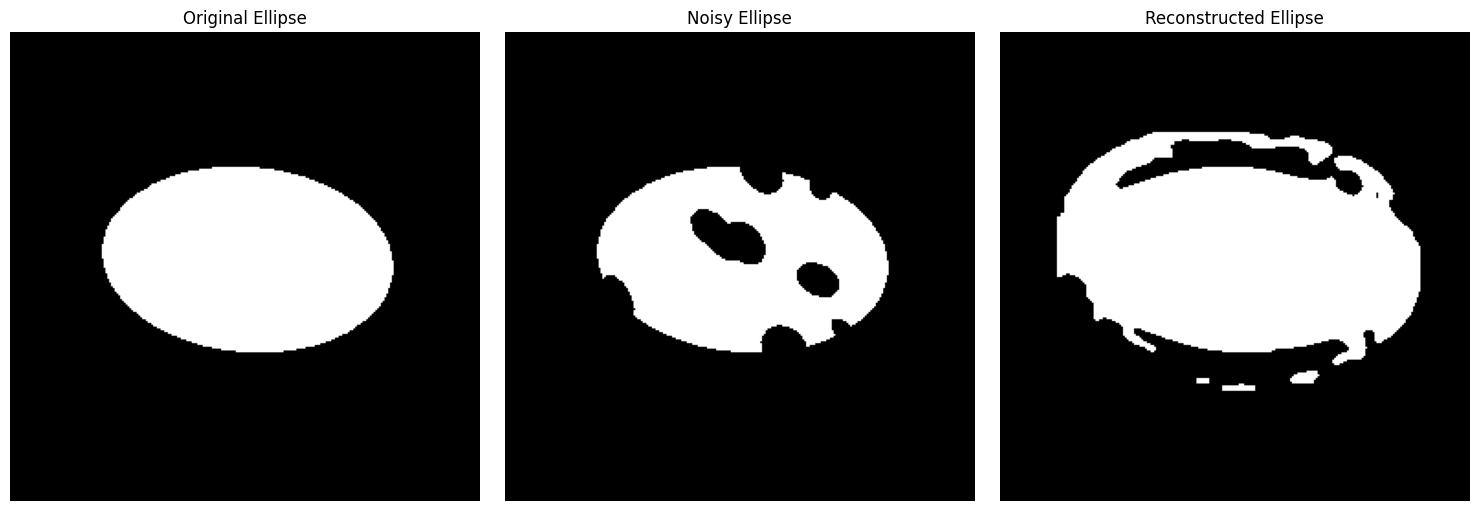

Image 8: Dice coefficient: 0.9009749666071494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


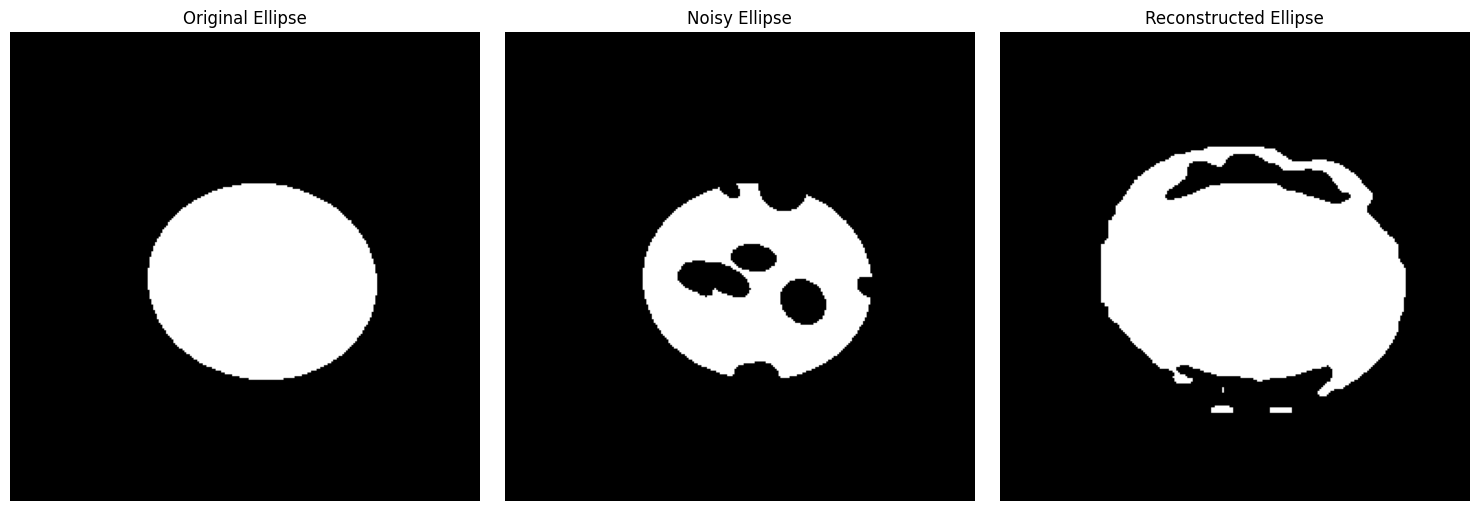

Image 9: Dice coefficient: 0.893288205960417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


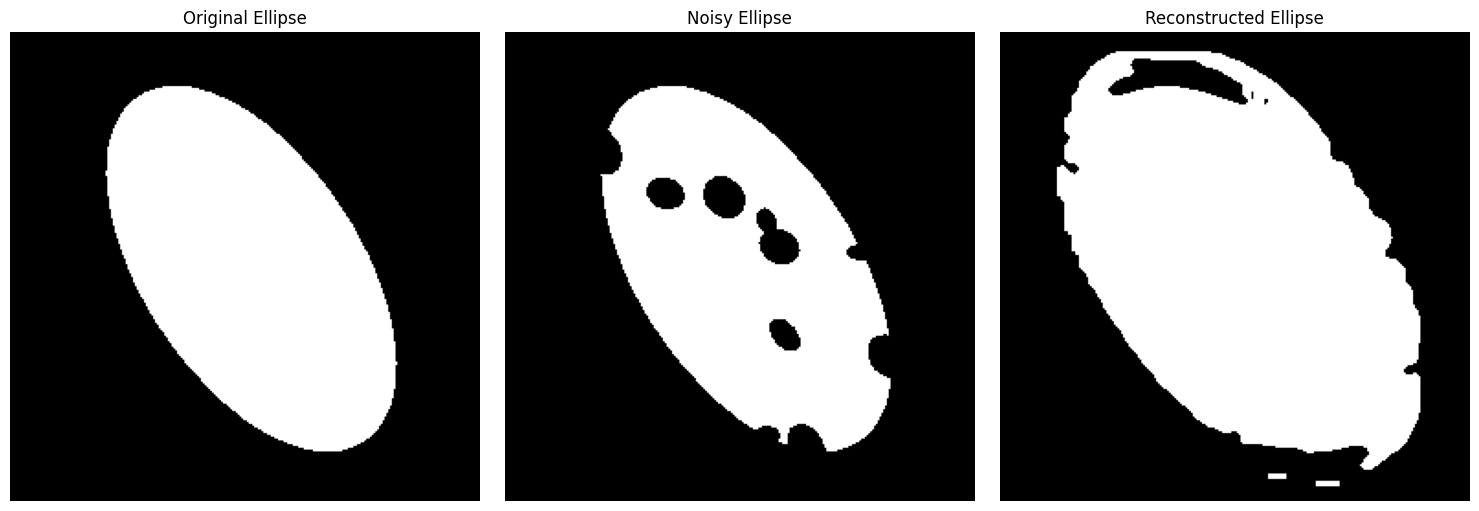

Image 10: Dice coefficient: 0.8848567231758581
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


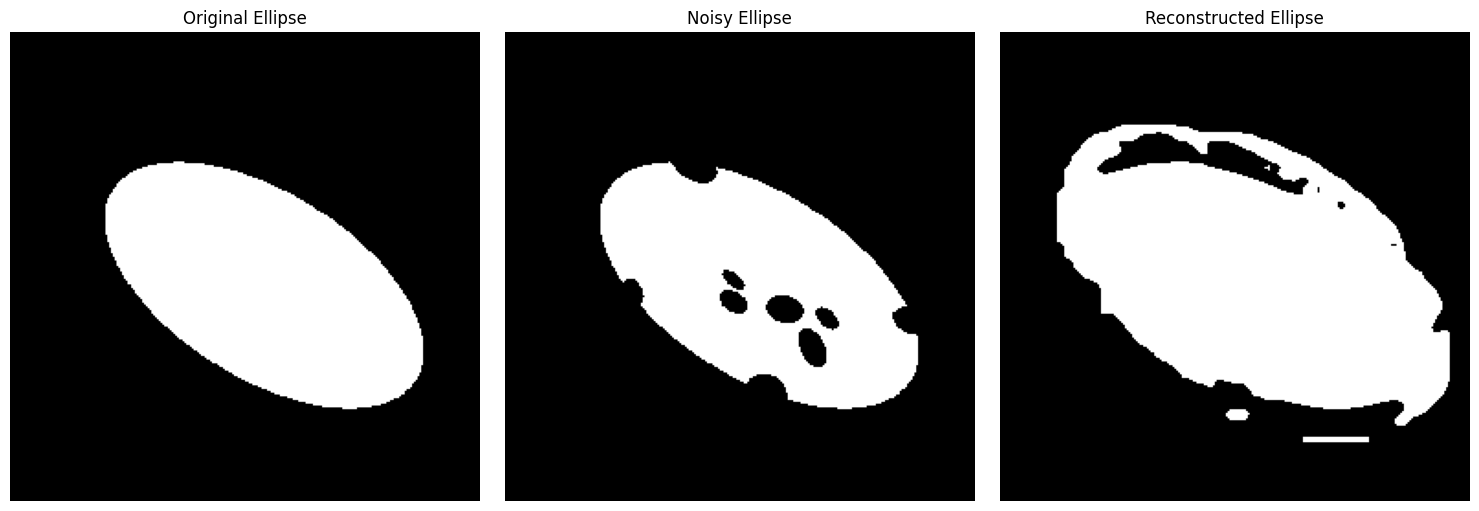

Image 11: Dice coefficient: 0.8761345594346924
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


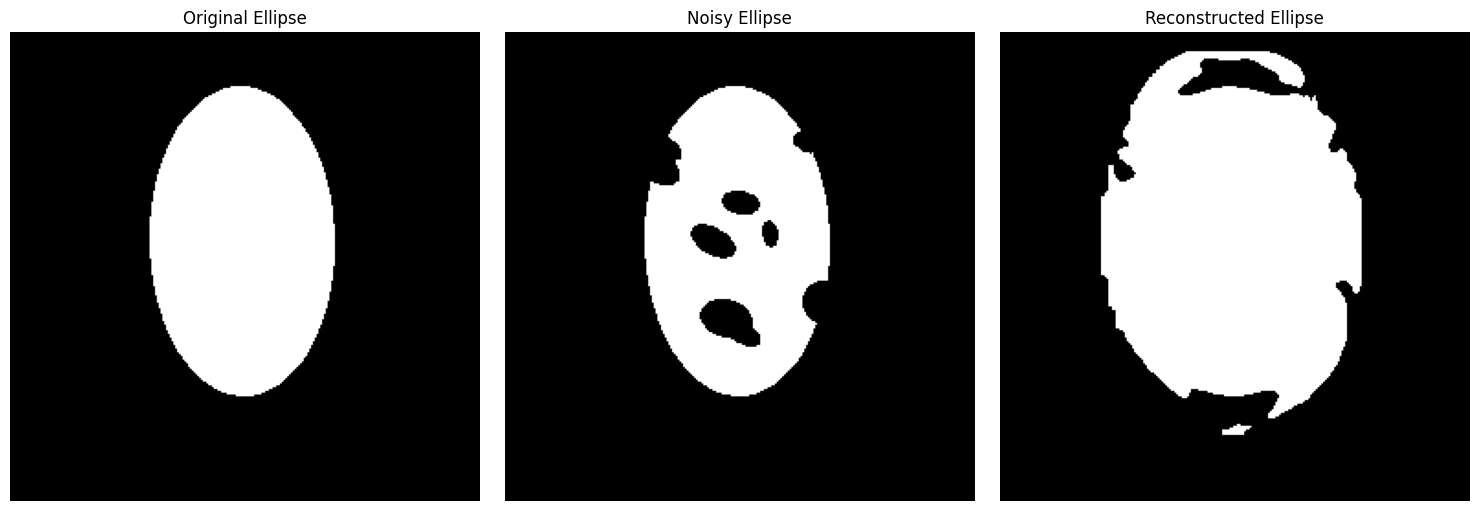

Image 12: Dice coefficient: 0.8901942101616392
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


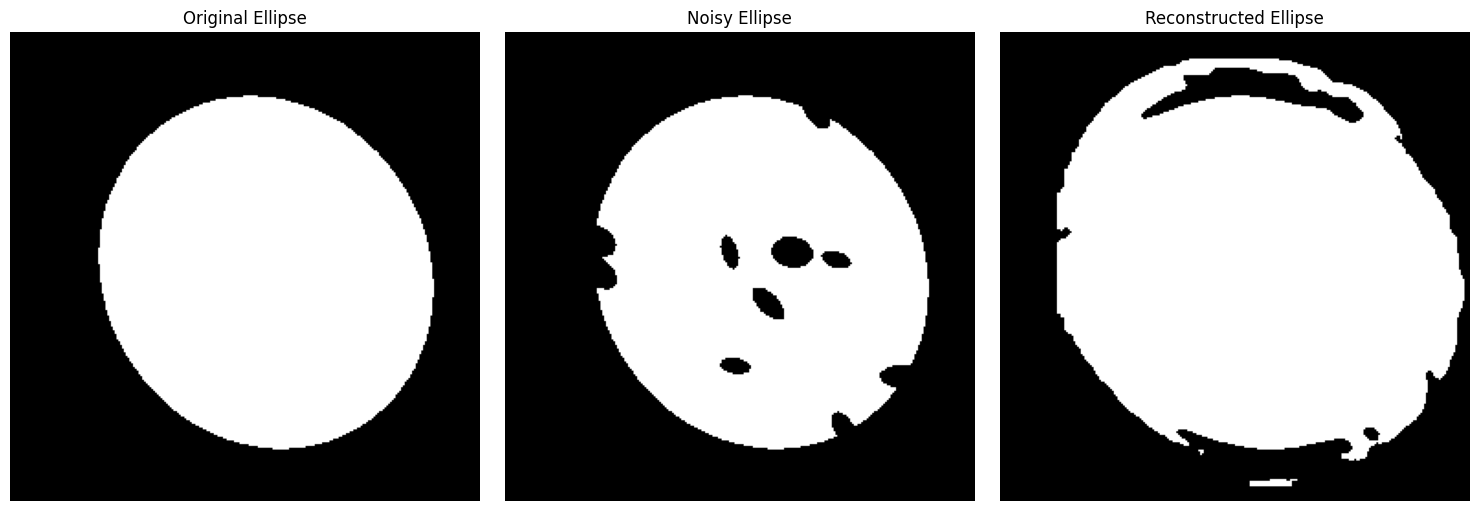

Image 13: Dice coefficient: 0.9125498026231129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


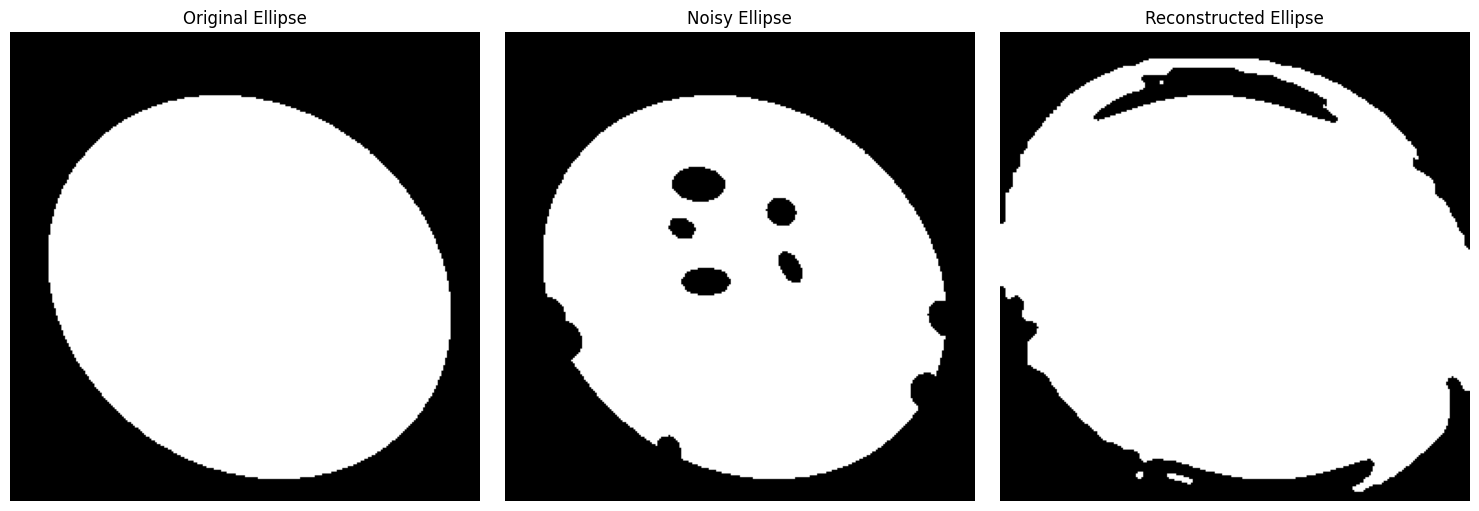

Image 14: Dice coefficient: 0.921226907187736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


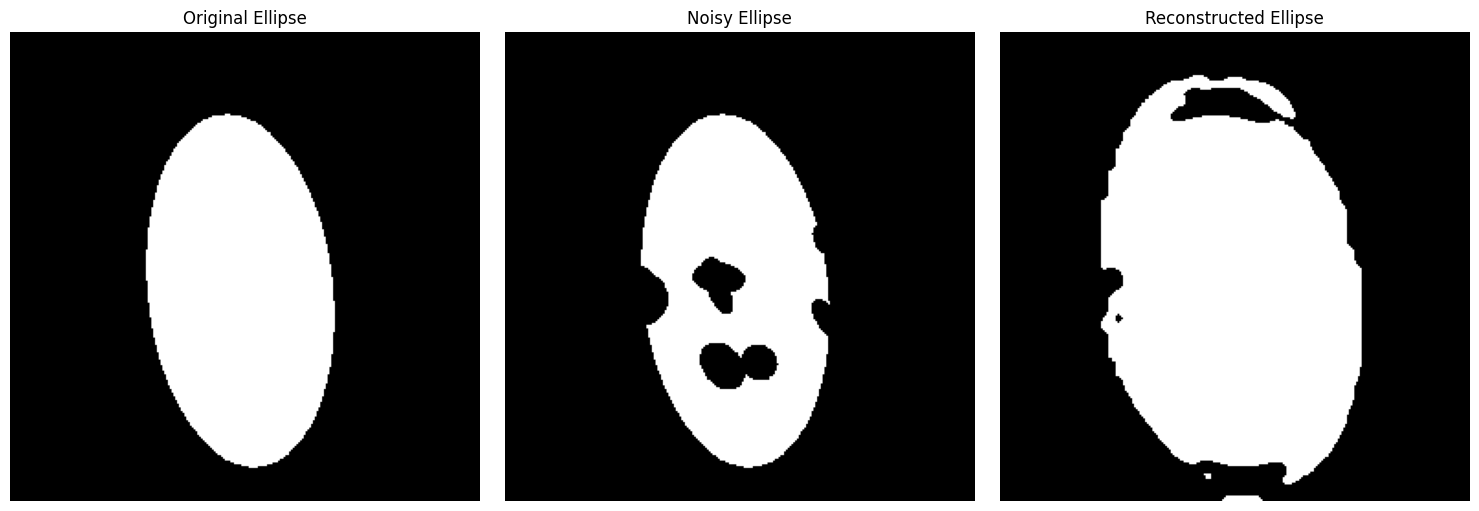

Image 15: Dice coefficient: 0.8936230613065134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


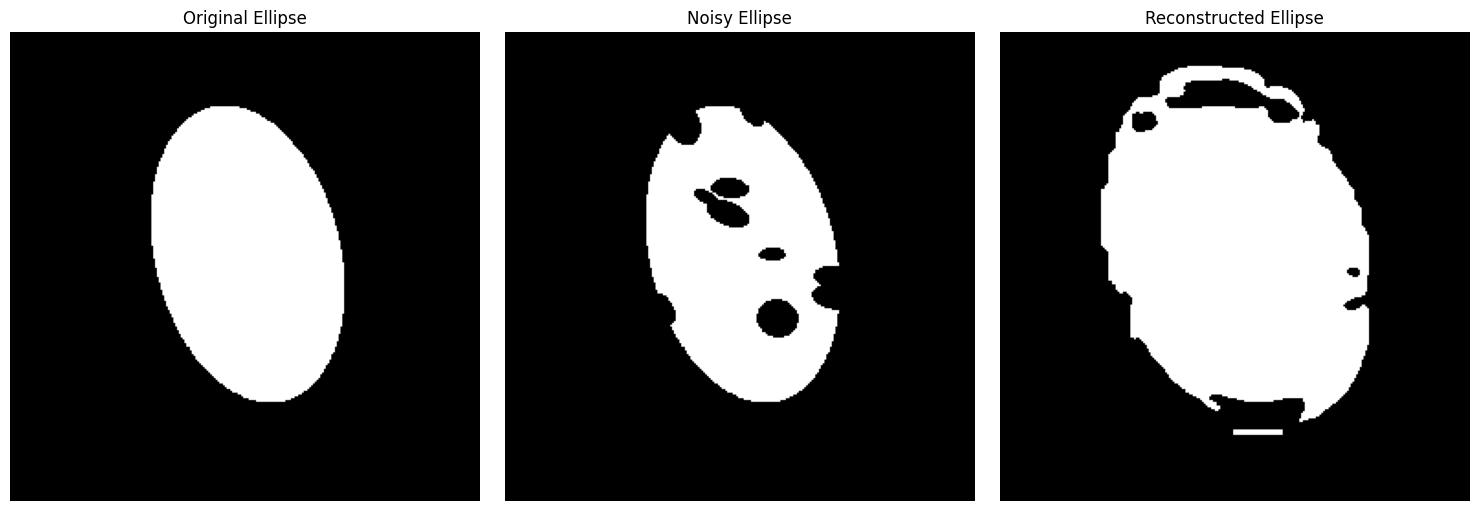

Image 16: Dice coefficient: 0.8898384399195607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


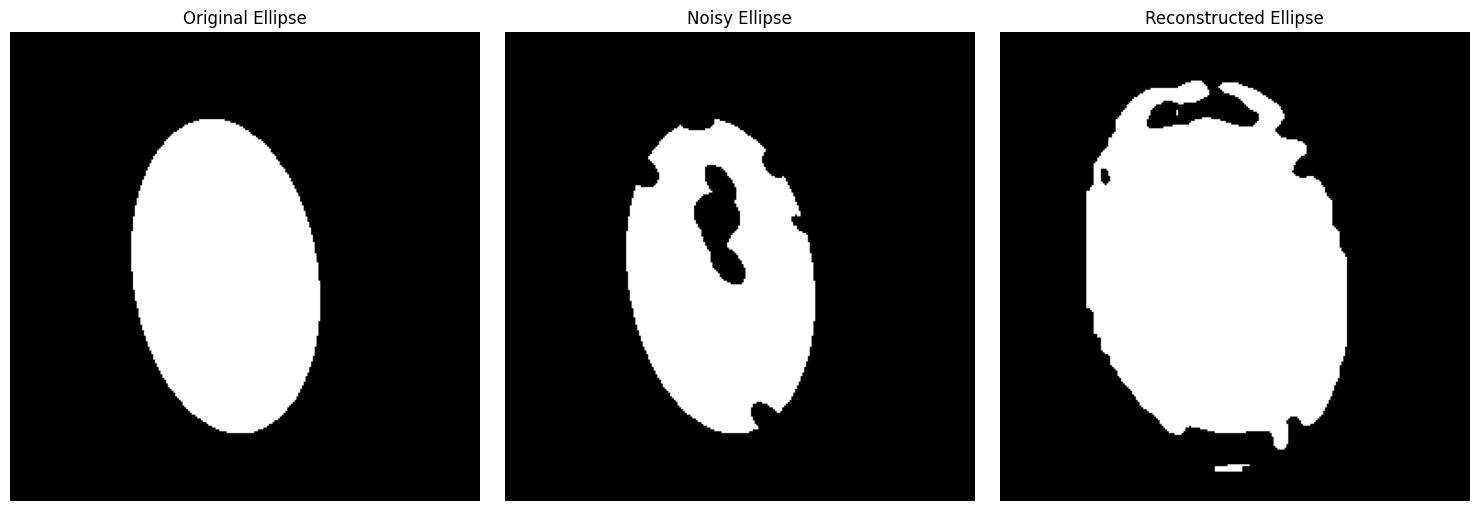

Image 17: Dice coefficient: 0.8934443605278607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


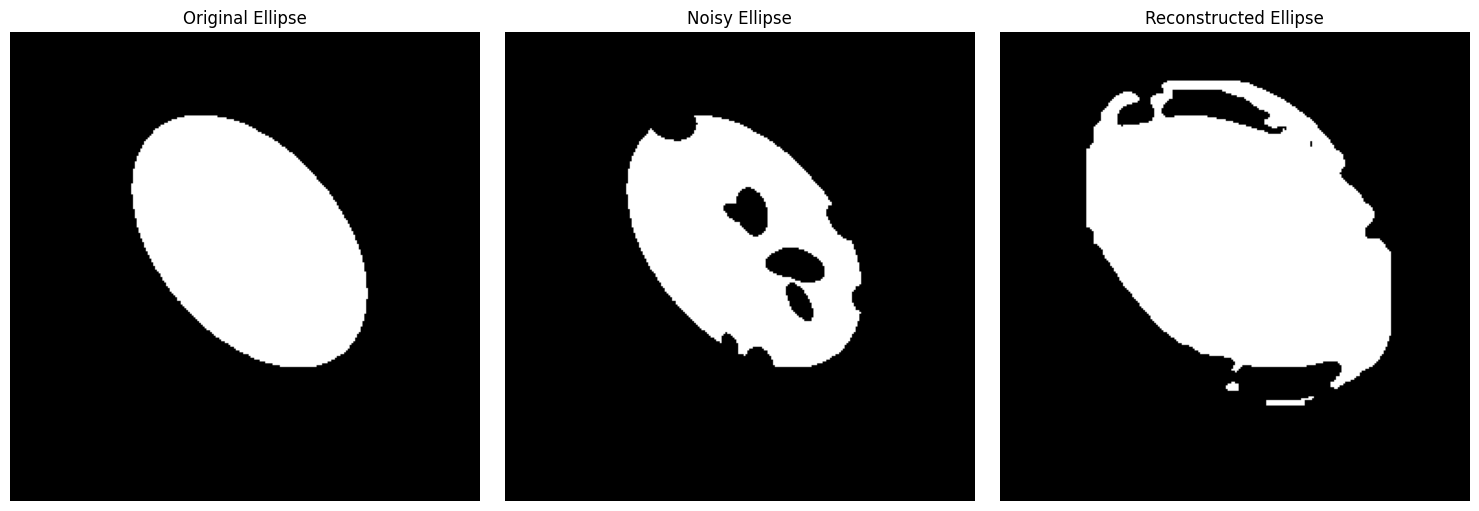

Image 18: Dice coefficient: 0.8777513221072653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


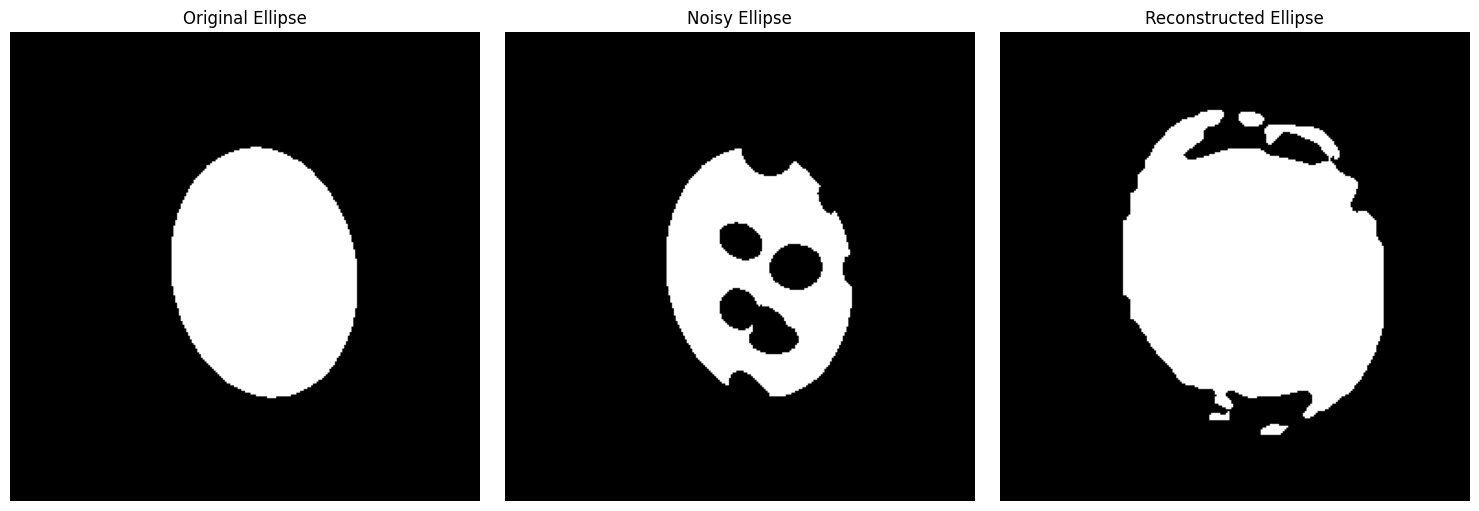

Image 19: Dice coefficient: 0.8907138469866205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


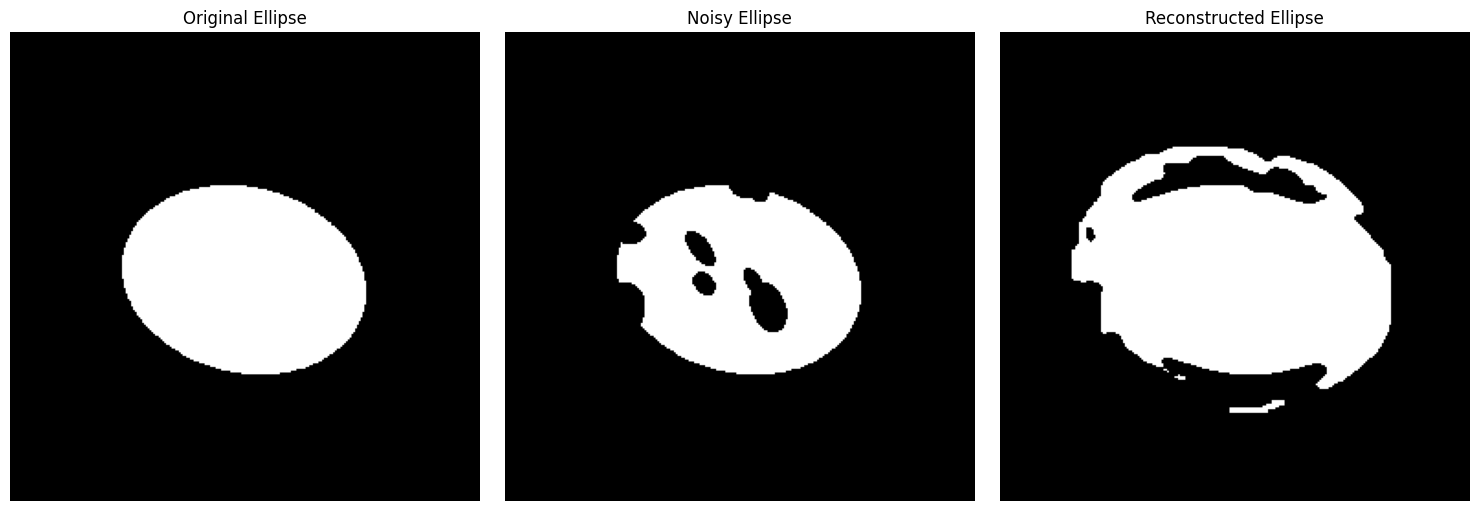

Image 20: Dice coefficient: 0.8890715941026563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


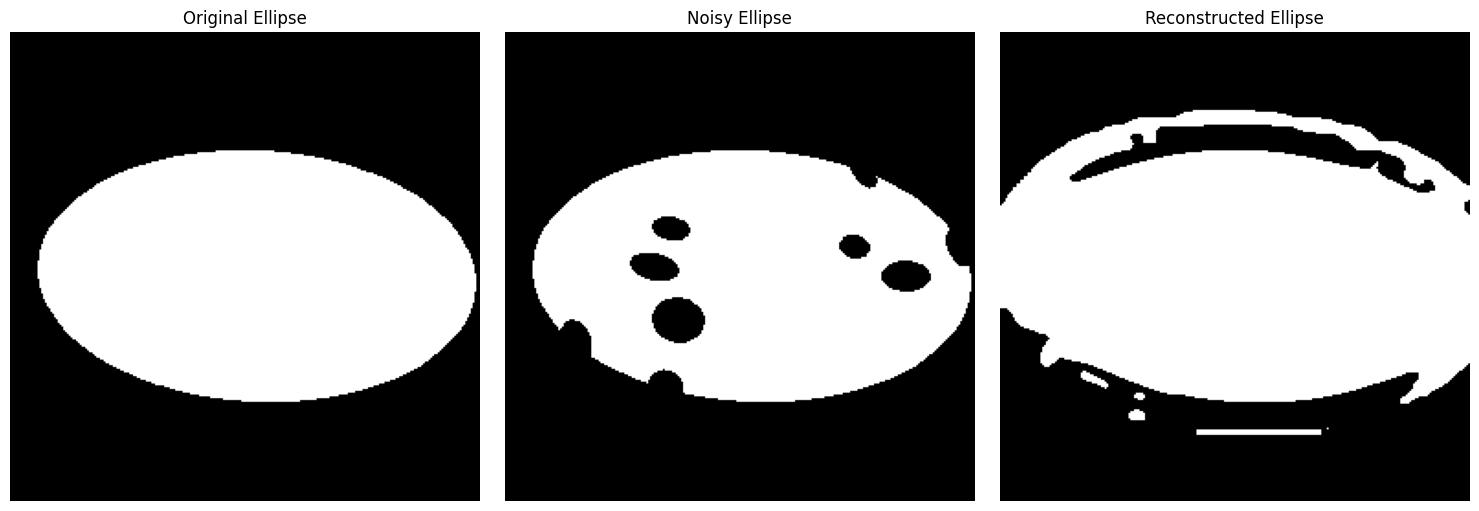

Image 21: Dice coefficient: 0.9171737989449437
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


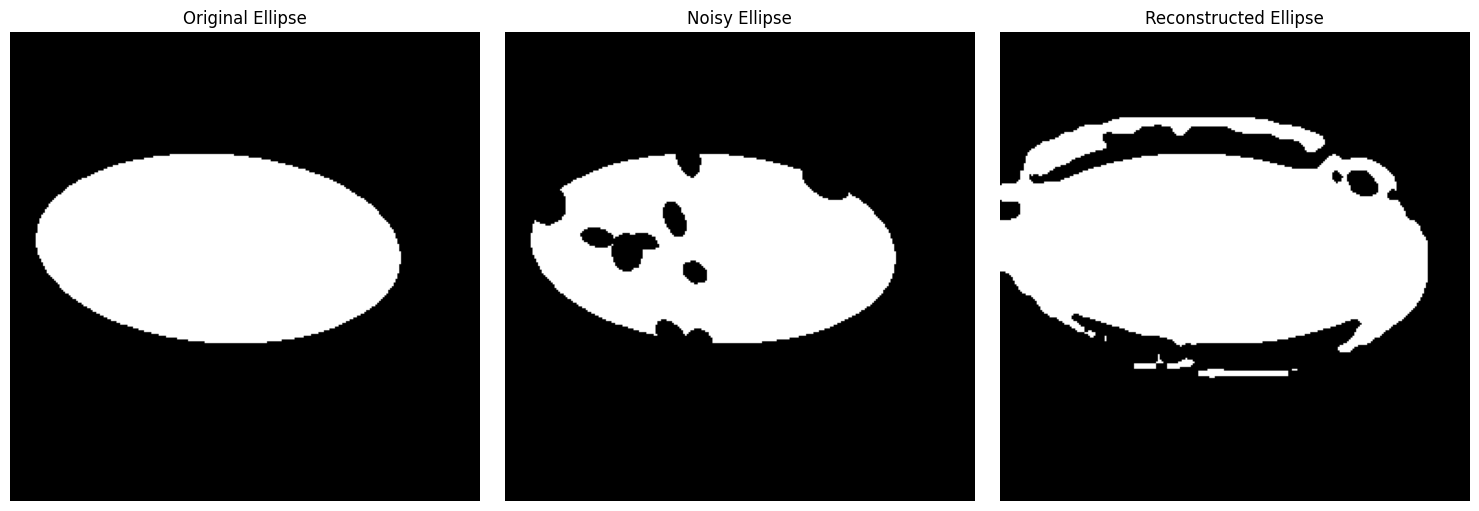

Image 22: Dice coefficient: 0.9074010065688509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


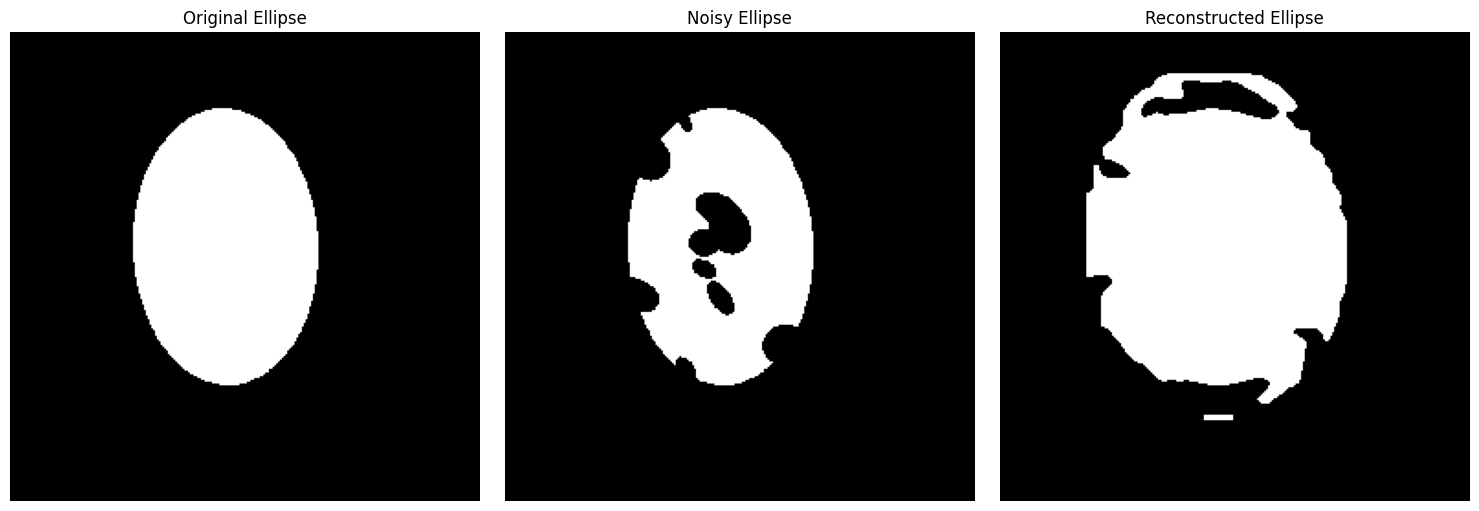

Image 23: Dice coefficient: 0.8947053836144095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


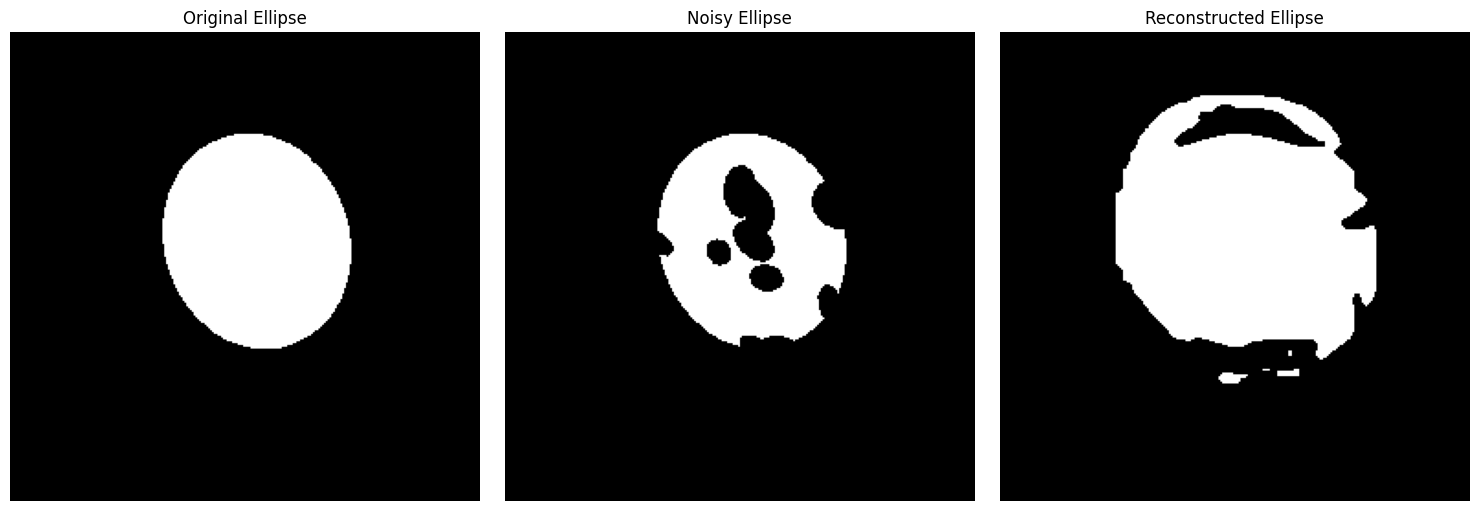

Image 24: Dice coefficient: 0.8801138404538649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


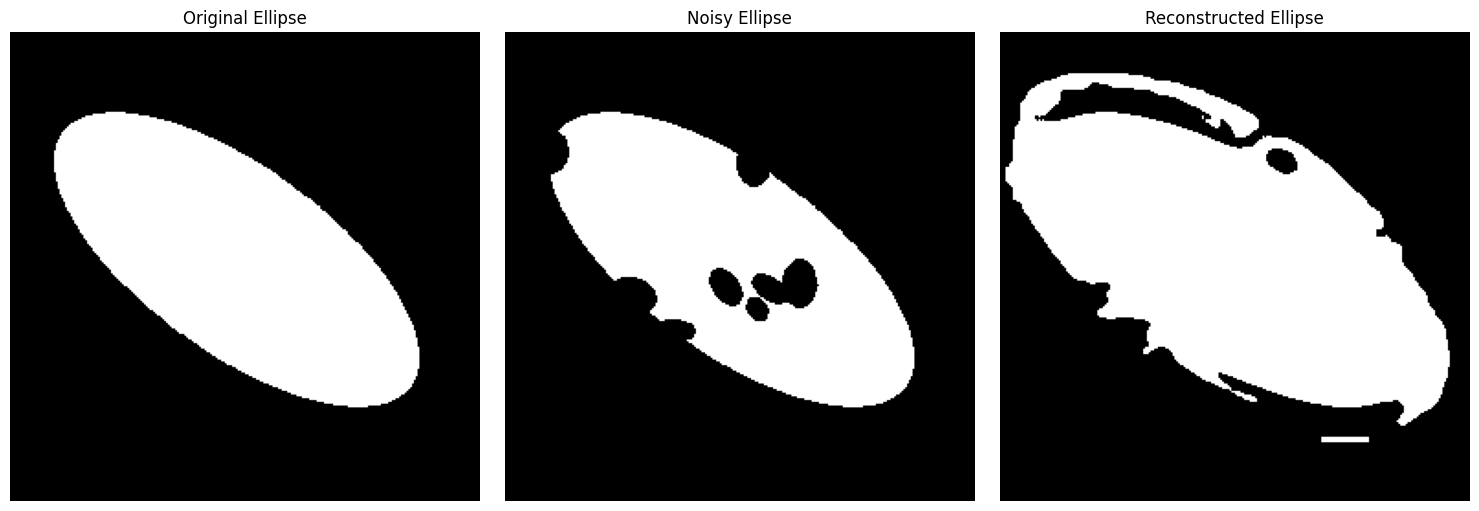

Image 25: Dice coefficient: 0.8782548602761956
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


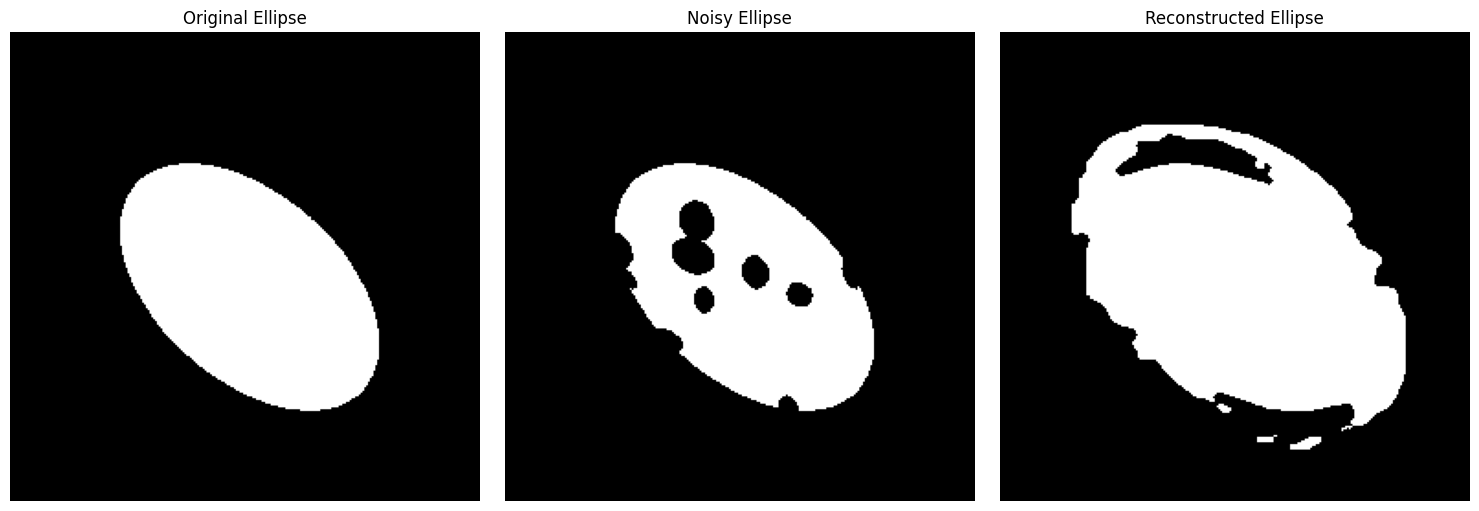

Image 26: Dice coefficient: 0.873336358328015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


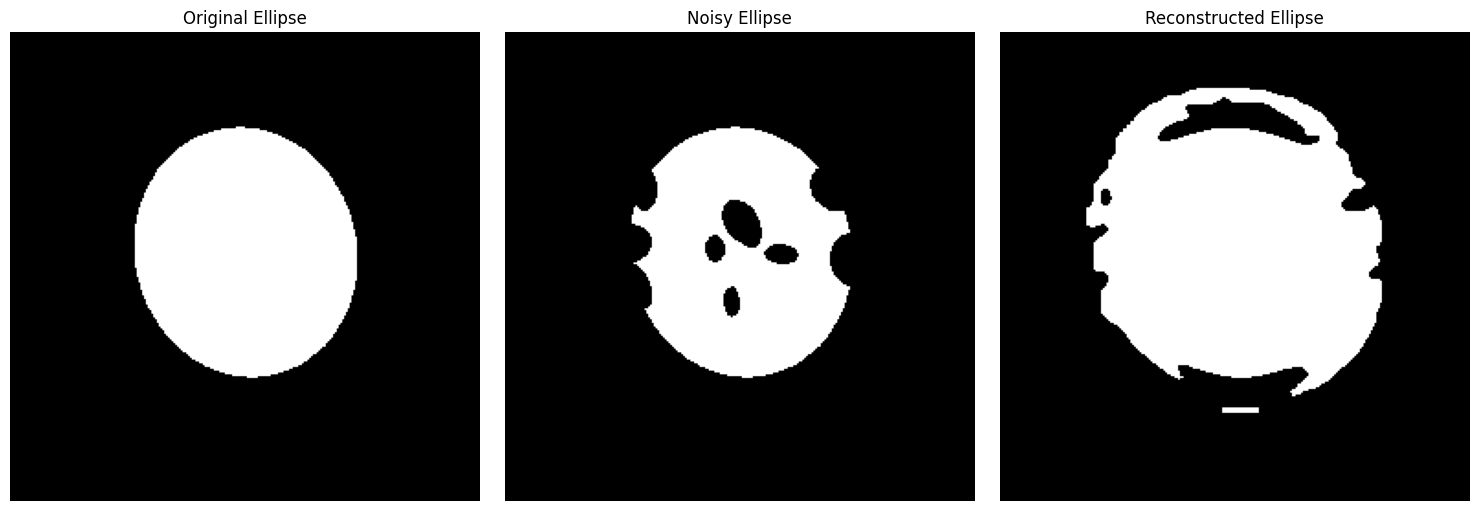

Image 27: Dice coefficient: 0.8904844505526579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


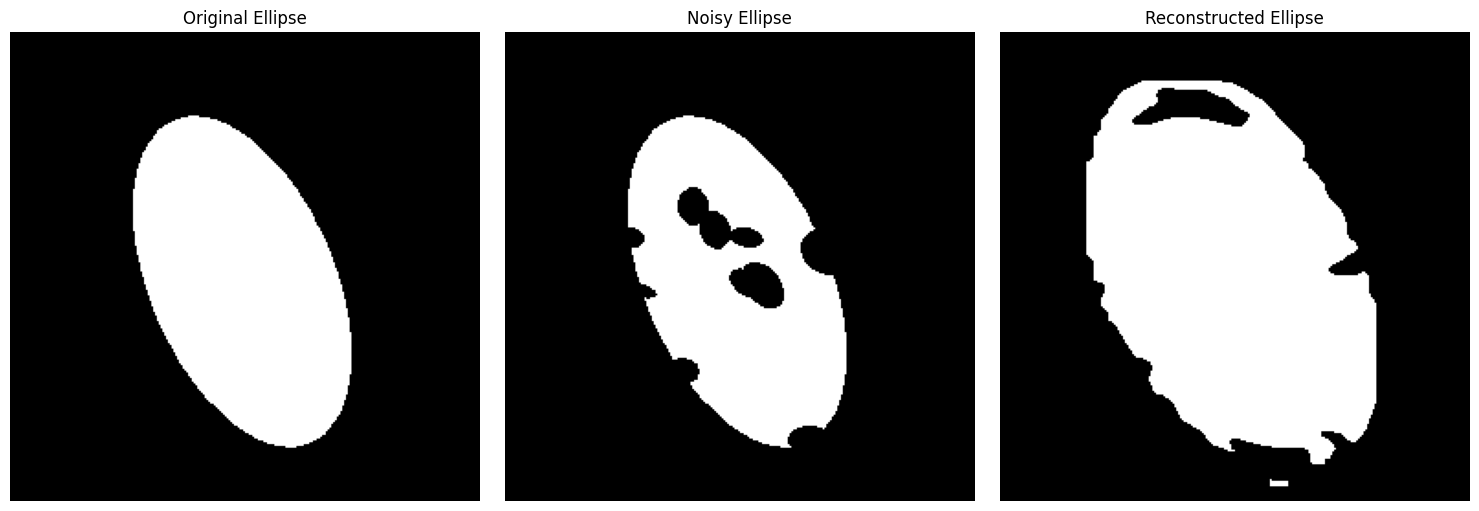

Image 28: Dice coefficient: 0.8785890282910587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


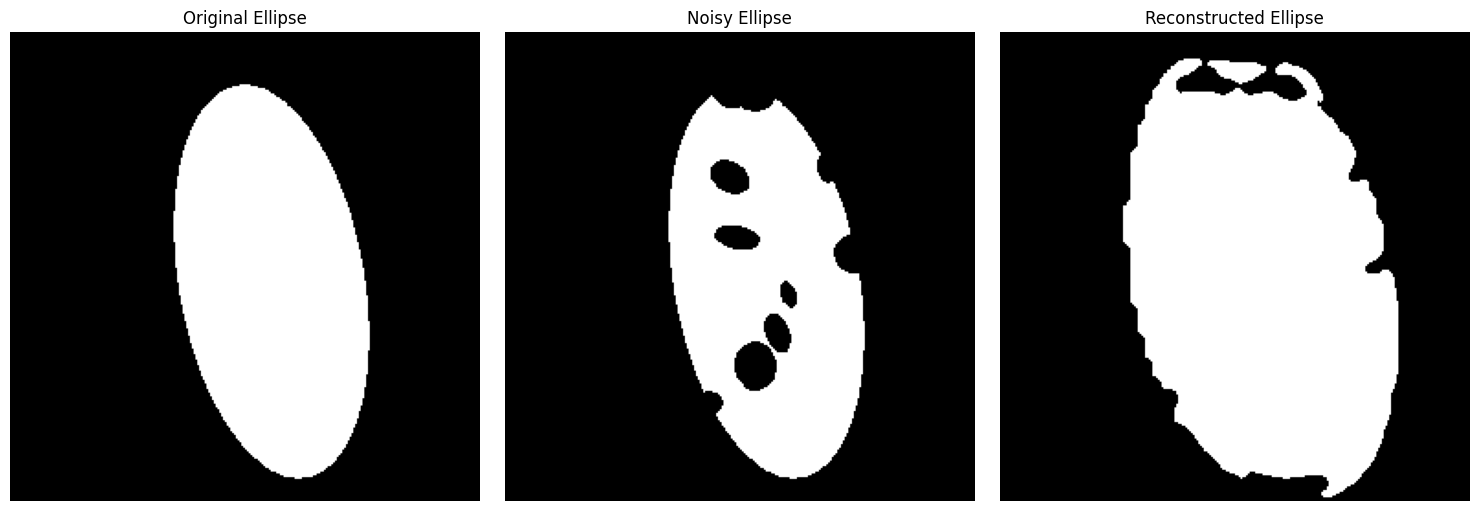

Image 29: Dice coefficient: 0.8975328151528242
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


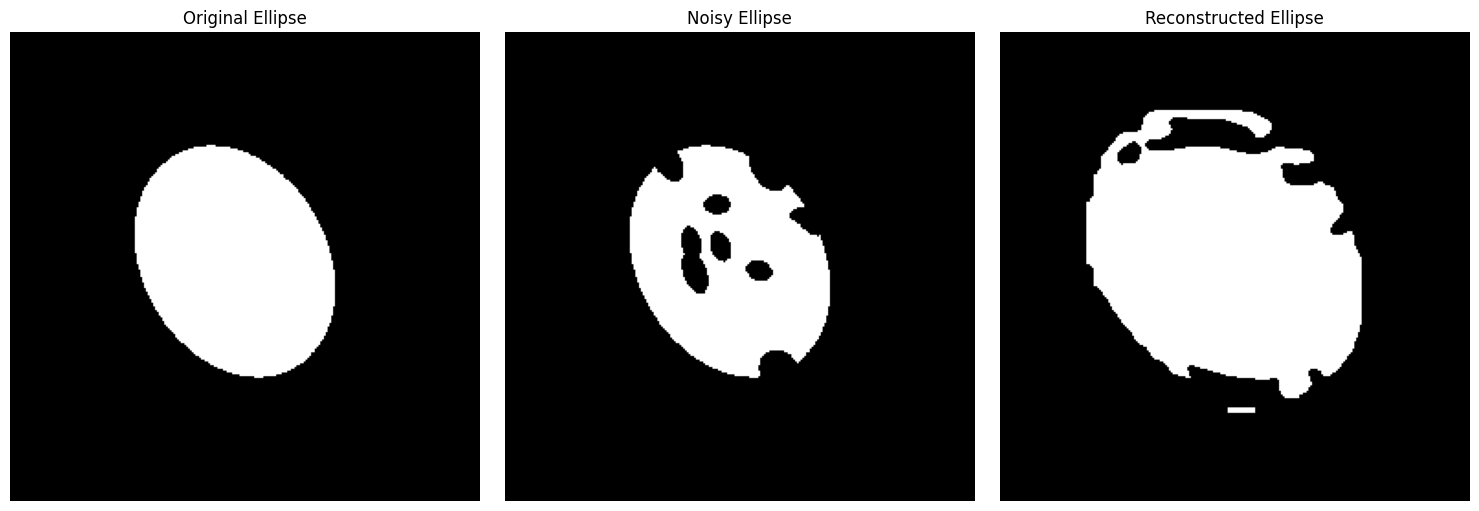

Image 30: Dice coefficient: 0.8895116514967791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


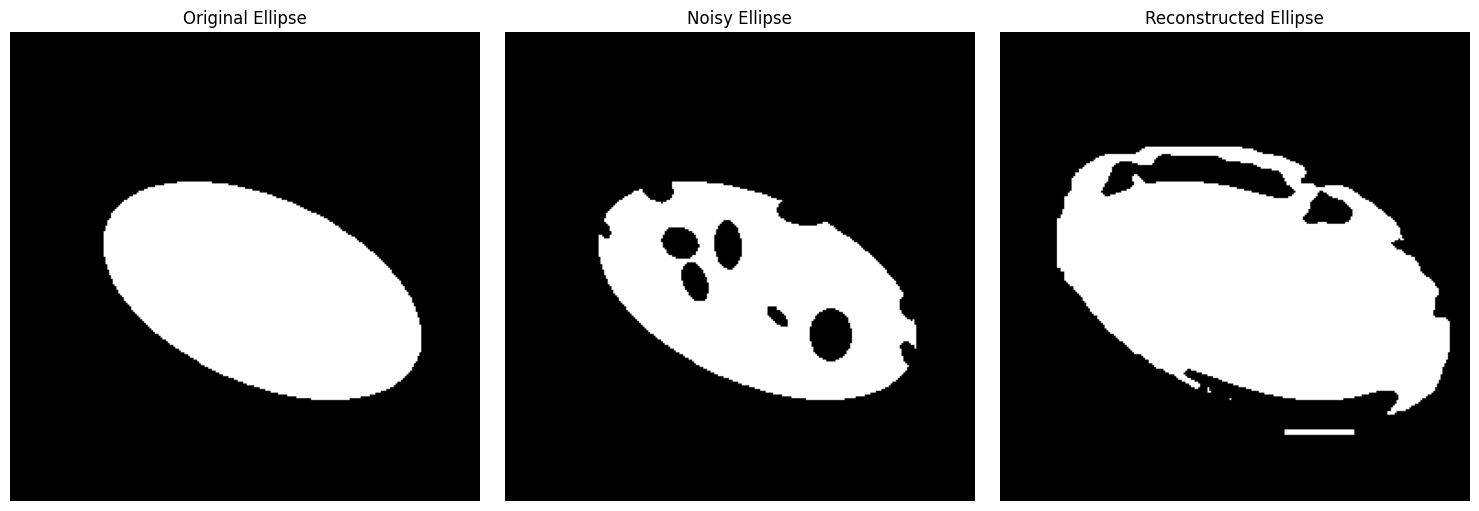

Image 31: Dice coefficient: 0.8959644662291731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


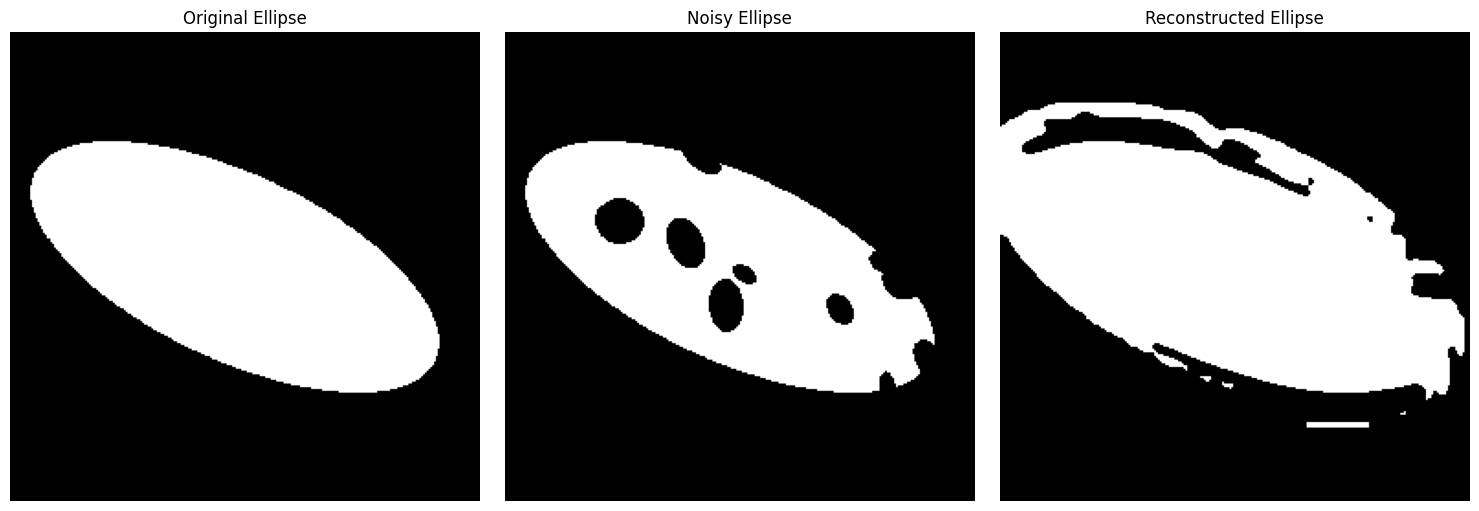

Image 32: Dice coefficient: 0.886753583205195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


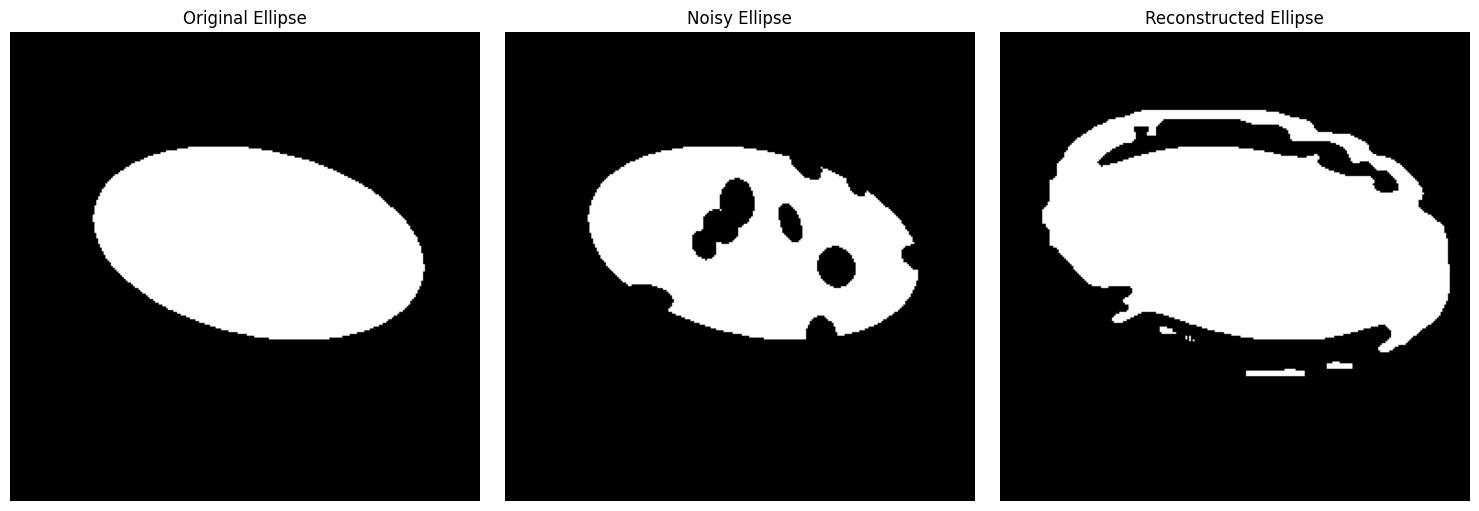

Image 33: Dice coefficient: 0.9085862822113431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


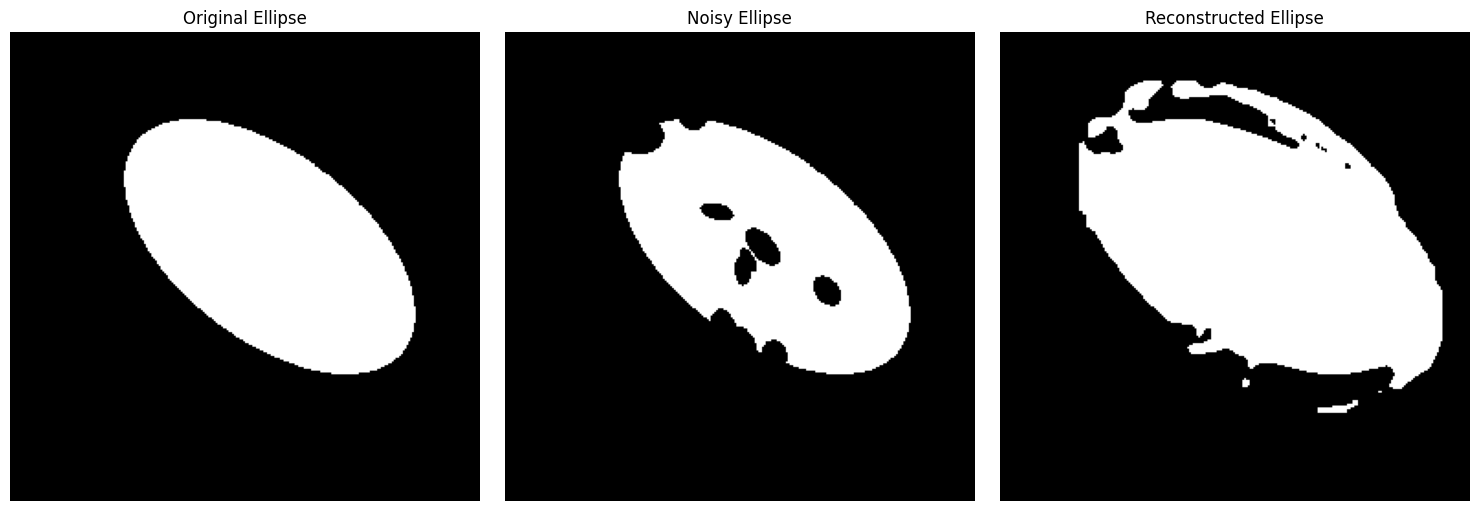

Image 34: Dice coefficient: 0.8730819284264794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


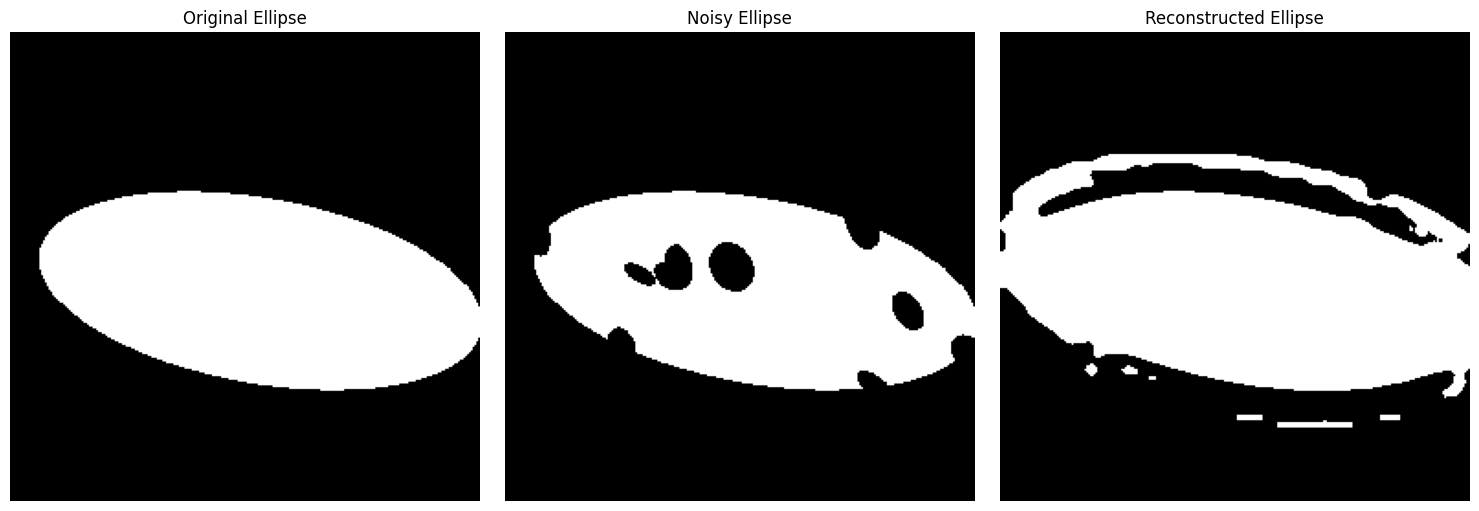

Image 35: Dice coefficient: 0.914718080257385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


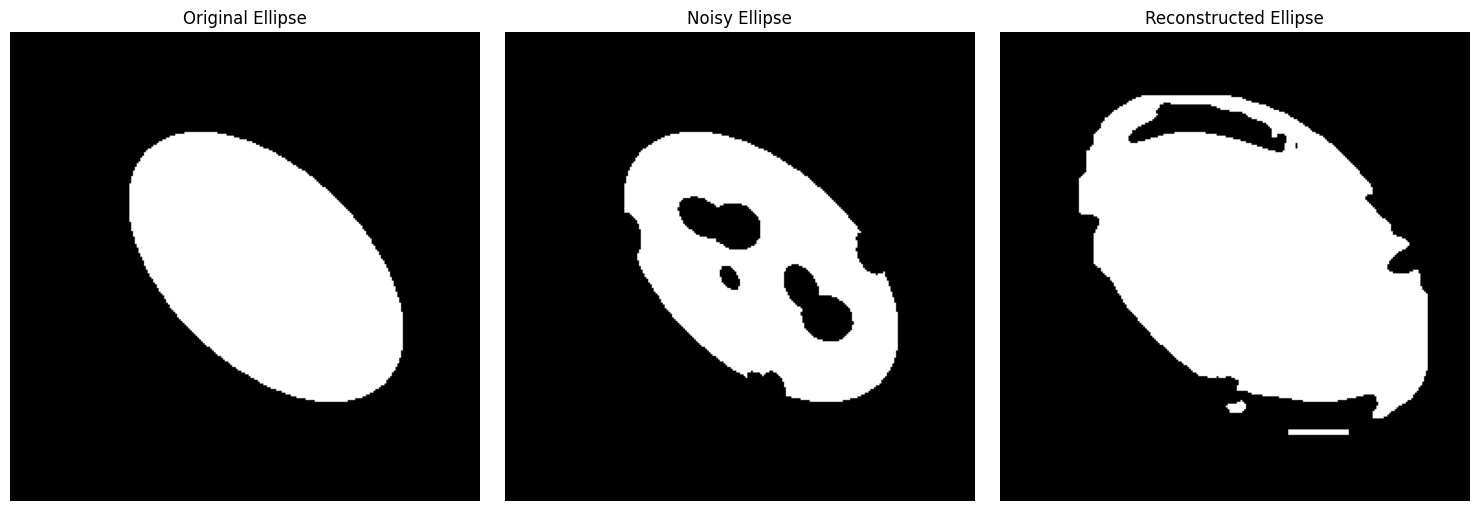

Image 36: Dice coefficient: 0.8783547486161187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


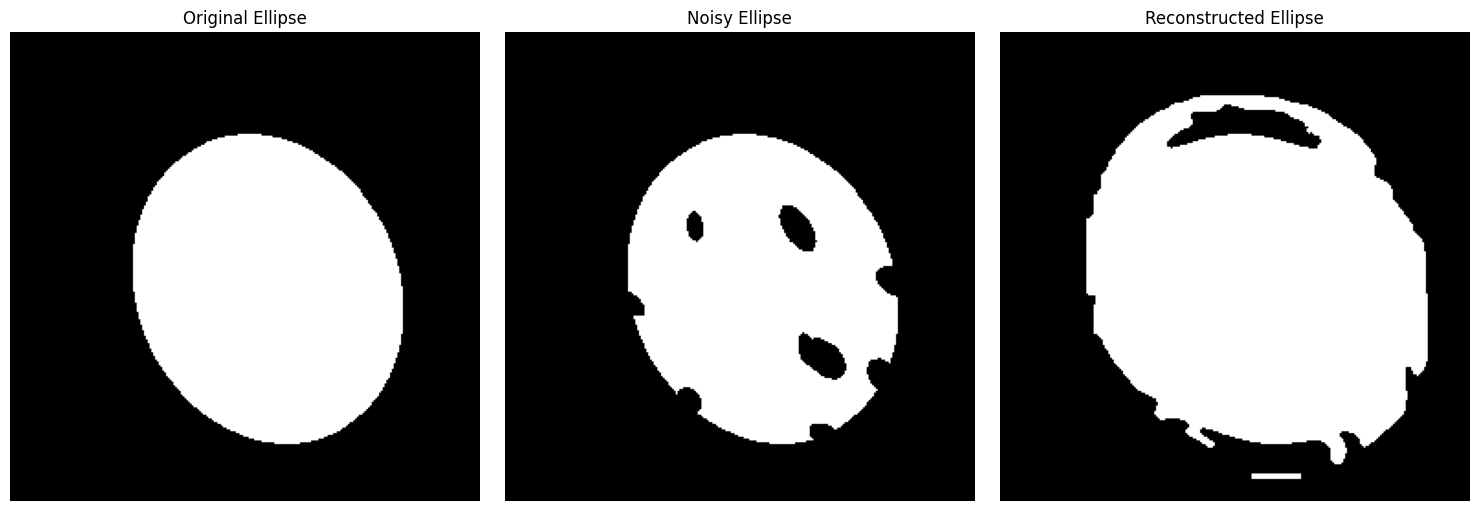

Image 37: Dice coefficient: 0.8991884798596547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


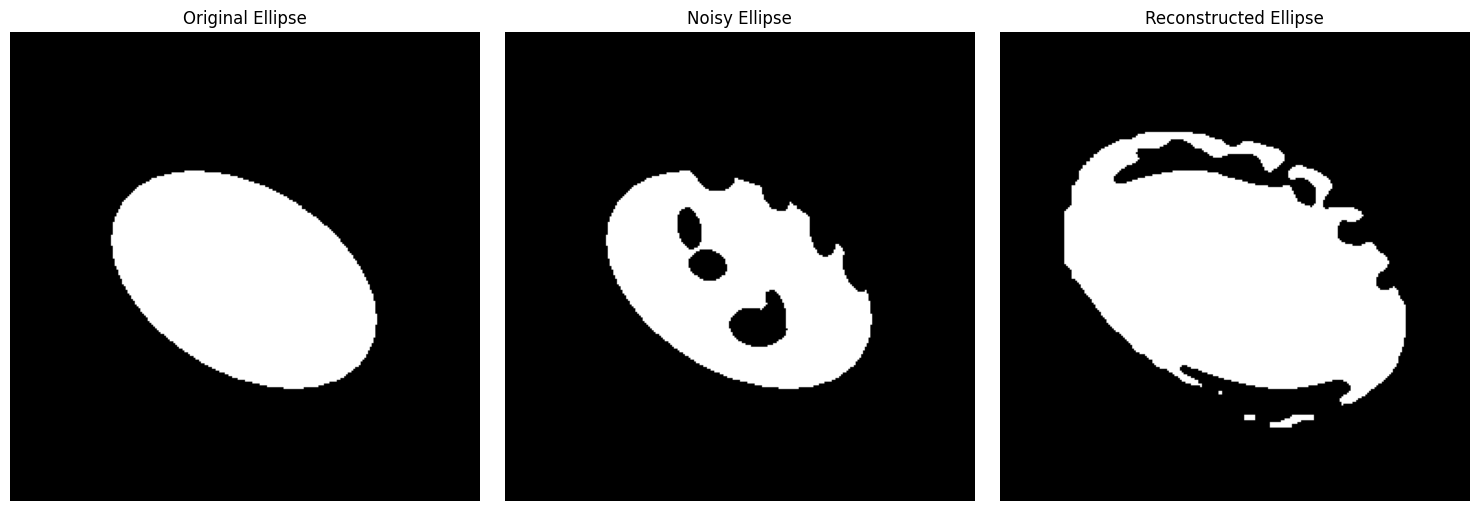

Image 38: Dice coefficient: 0.8934112583269637
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


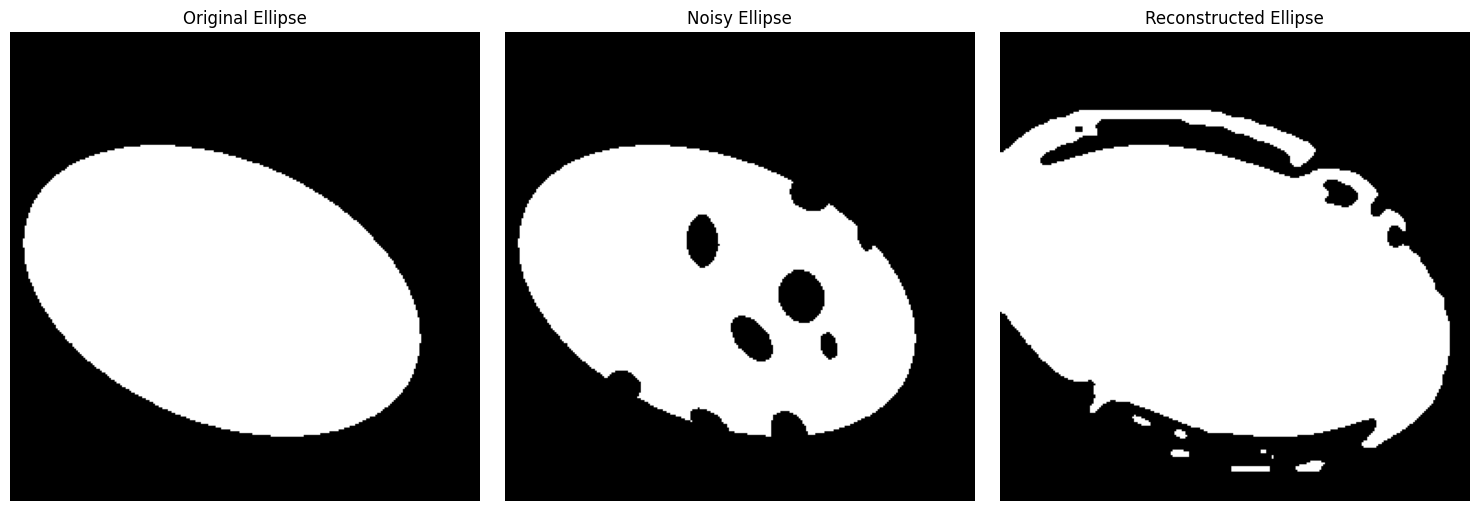

Image 39: Dice coefficient: 0.9177171721555177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


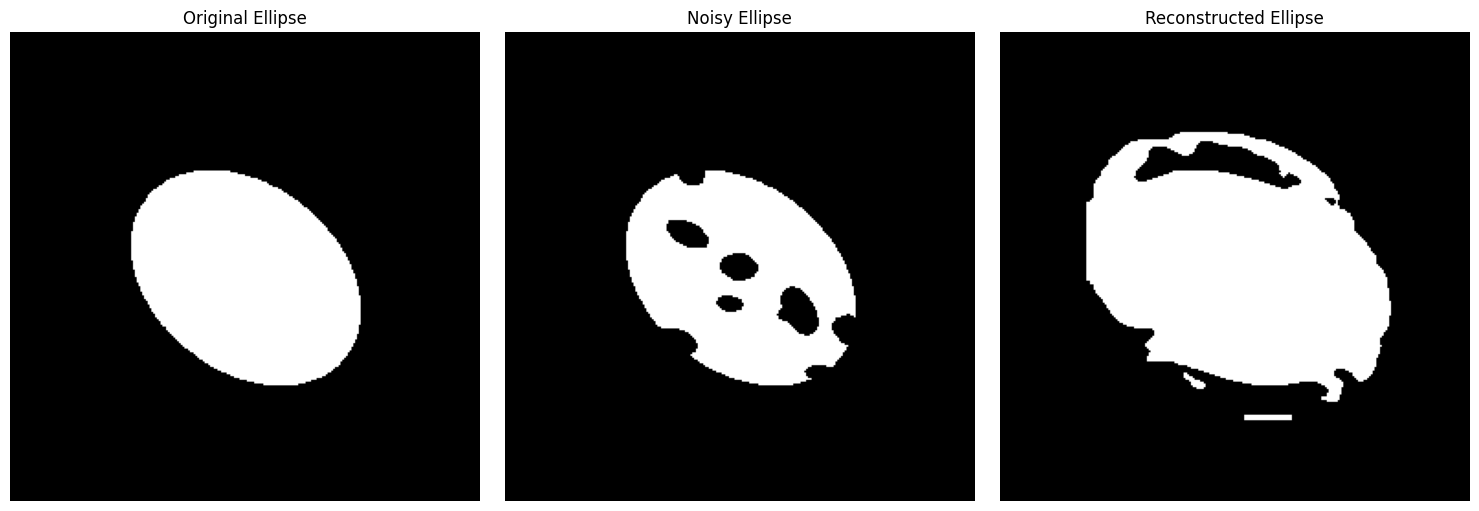

Image 40: Dice coefficient: 0.8880318488010931
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


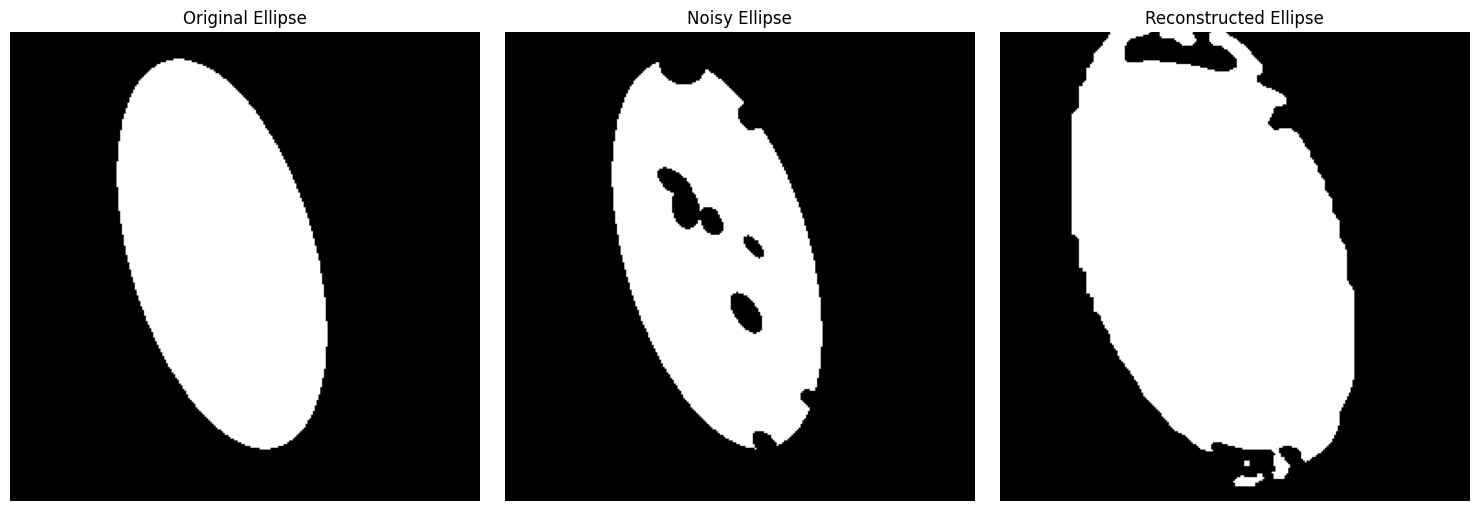

Image 41: Dice coefficient: 0.8887005988783396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


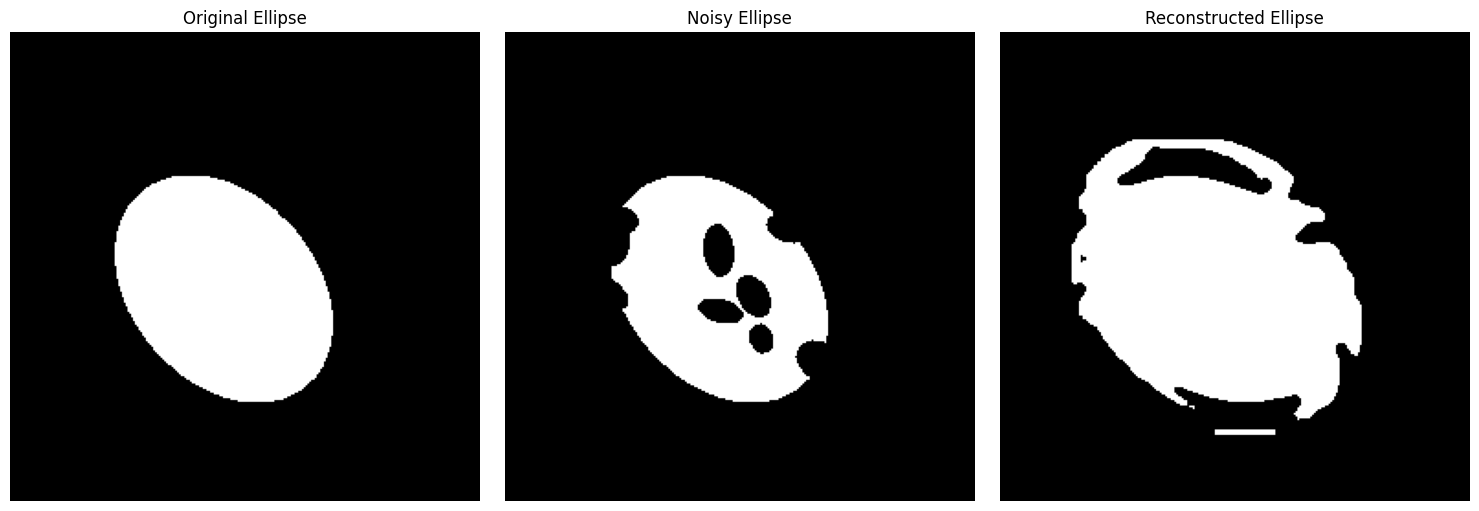

Image 42: Dice coefficient: 0.8861556389857355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


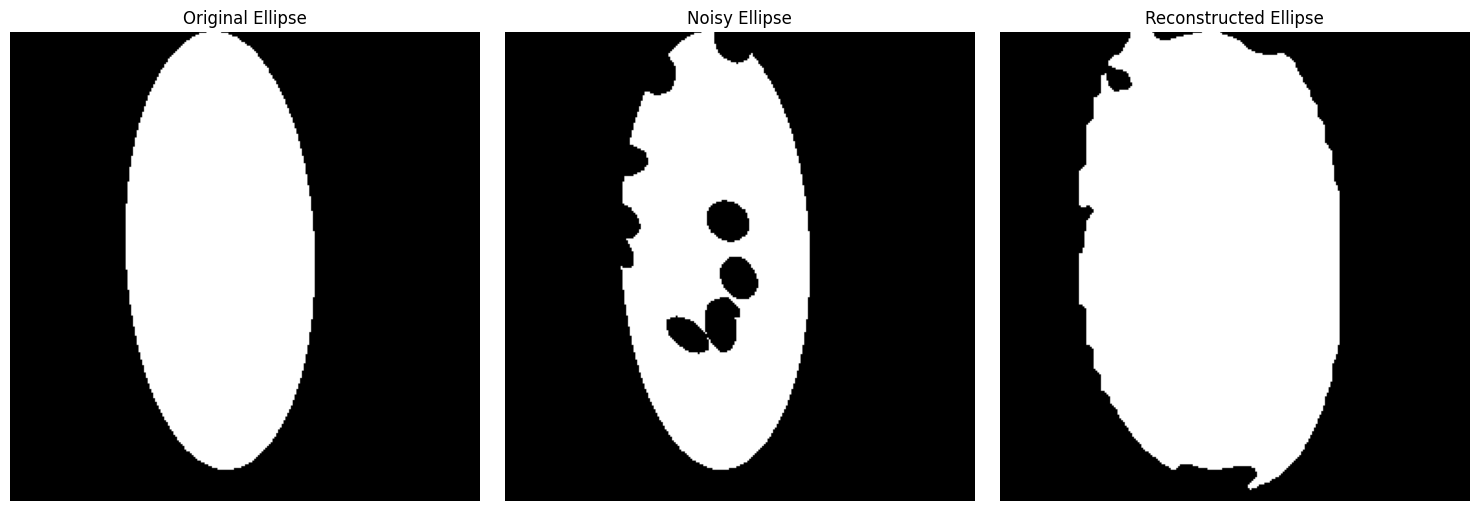

Image 43: Dice coefficient: 0.9217894614896638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


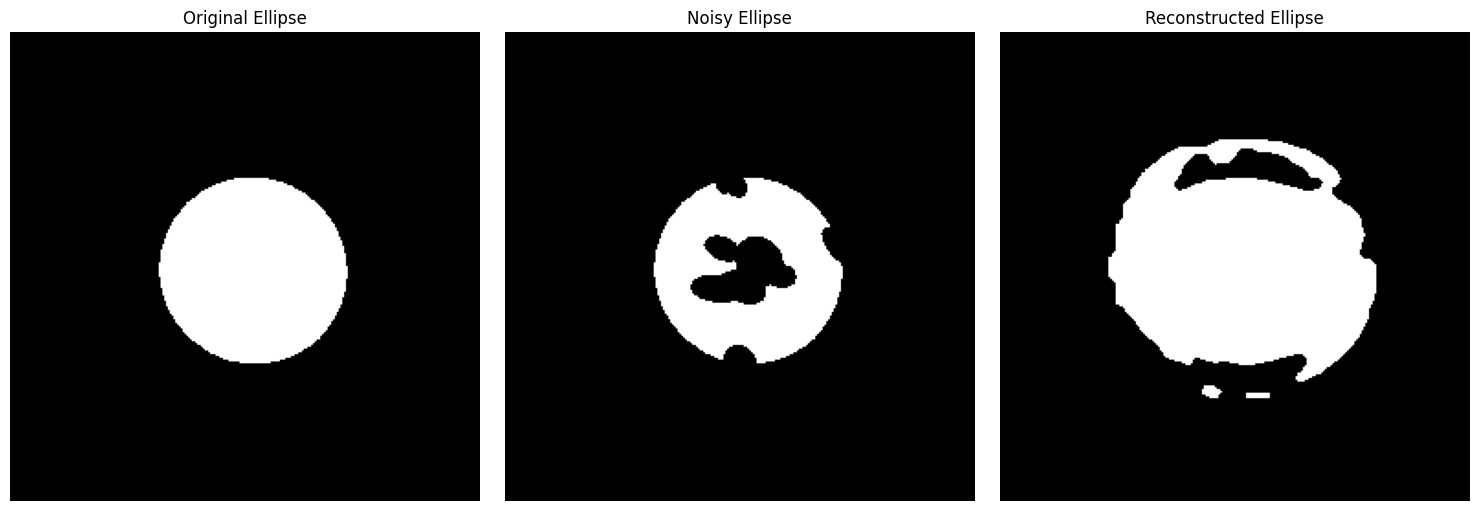

Image 44: Dice coefficient: 0.8758130557121839
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


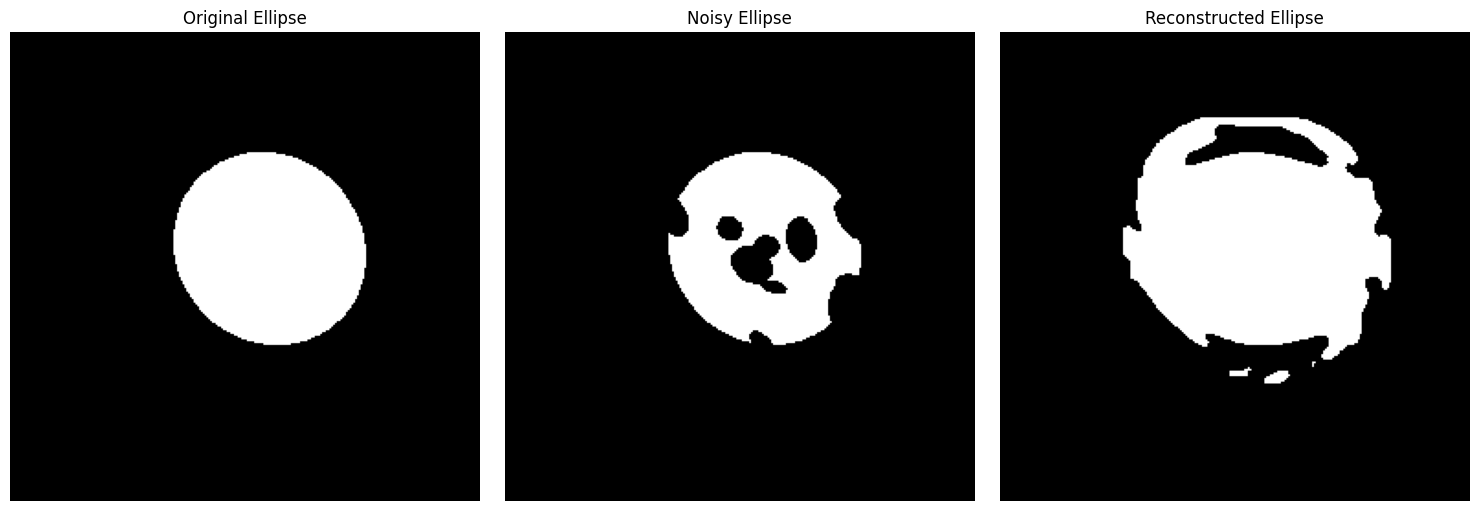

Image 45: Dice coefficient: 0.88214053605678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


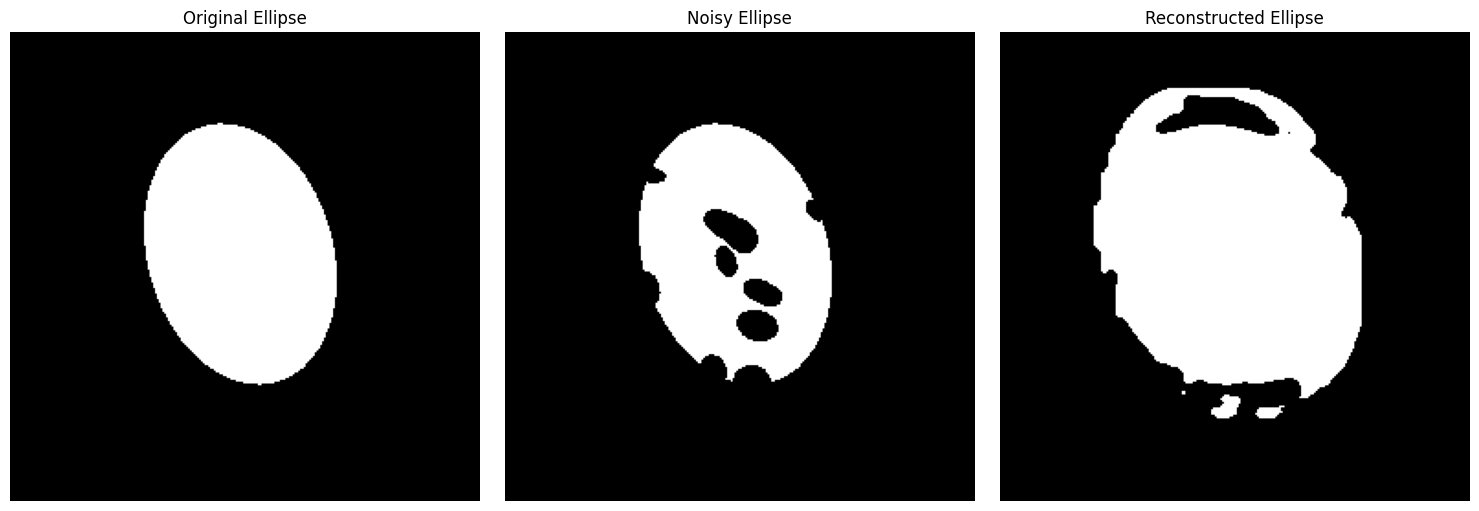

Image 46: Dice coefficient: 0.8795265302666222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


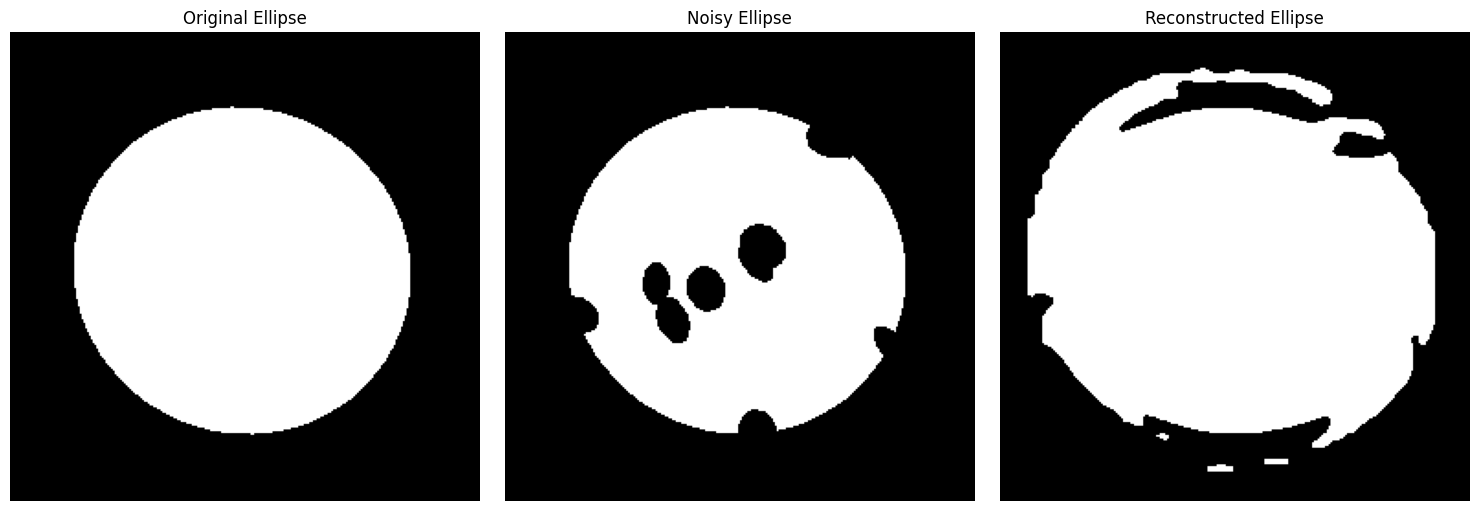

Image 47: Dice coefficient: 0.9162361828813814
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


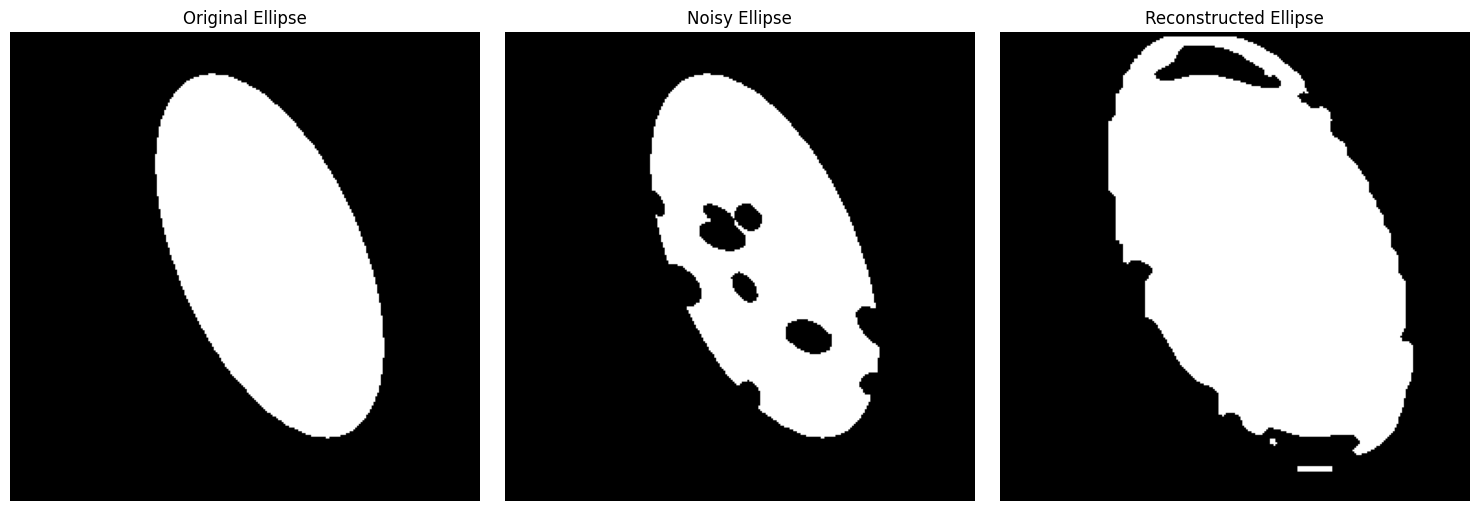

Image 48: Dice coefficient: 0.8791097089310512
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


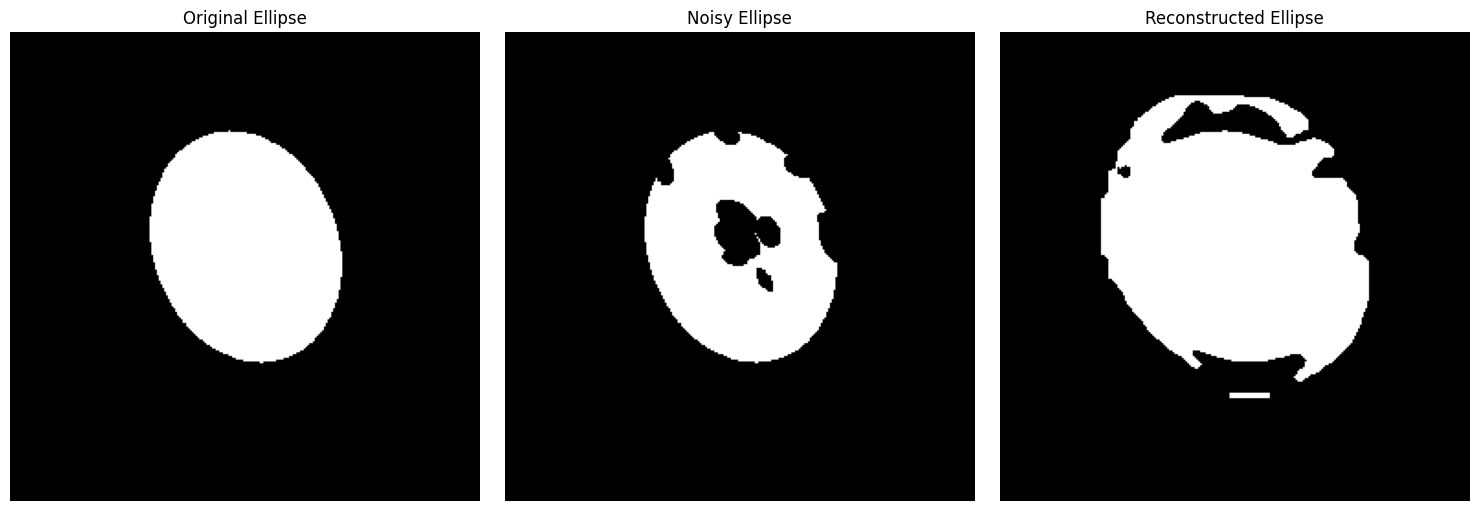

Image 49: Dice coefficient: 0.8859572974600164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


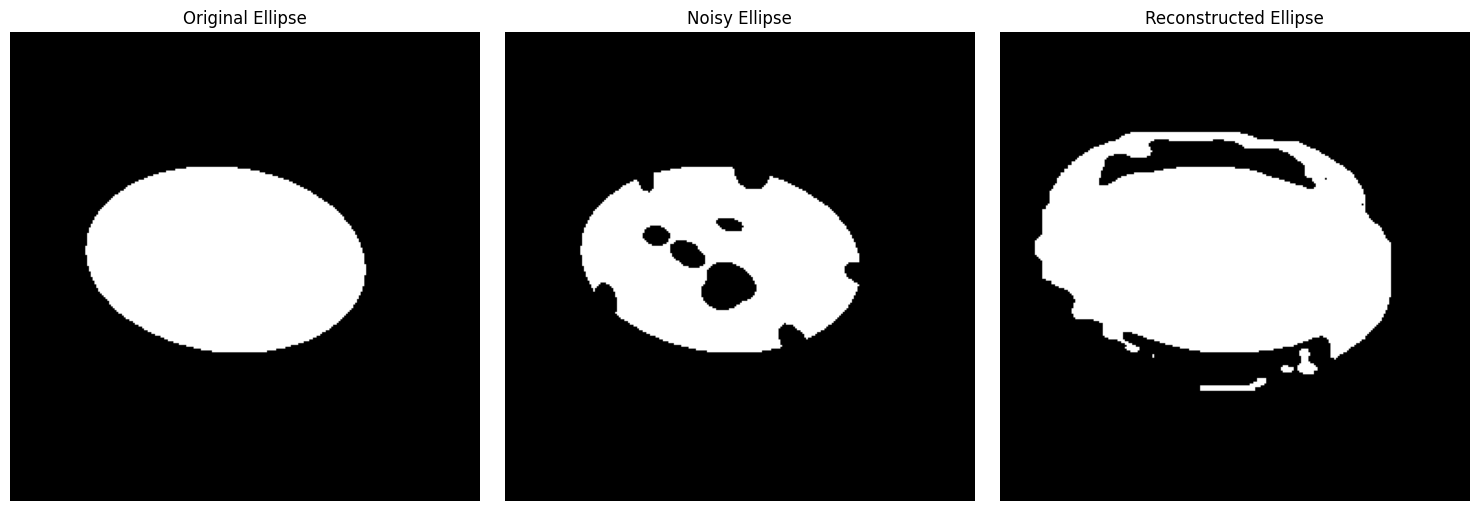

Image 50: Dice coefficient: 0.8981625723348172
Average Dice coefficient: 0.8928118307569796


In [47]:
from sklearn.metrics import f1_score
dice_coefficients = []
hausdorff_distances = []
path = "test"
# Generate 100 ellipses and save them to BMP files
# User can skip this step and load own images
test = EllipseDataset(50)
test.save_to_bmp(path)

autoencoder_ = keras.models.load_model("model_at_epoch_39.keras", custom_objects={"Autoencoder": Autoencoder})
autoencoder_.compile(optimizer="adam", loss="mse")

# wait for the ellipses to save 
import time
time.sleep(5)
#reading images
for i in range(50):
    ellipse = cv2.imread(f"{path}/original/original_{i}.bmp", cv2.IMREAD_GRAYSCALE)
    noisy_ellipse = cv2.imread(f"{path}/damaged/eroded_{i}.bmp", cv2.IMREAD_GRAYSCALE)
    
    # ellipse = test.ellipses[i]
    # noisy_ellipse = test.noisy_ellipses[i]
    
    reconstruction = autoencoder_.predict(noisy_ellipse.reshape(1, 256, 256, 1)).reshape(256, 256)
    reconstruction = cv2.normalize(reconstruction, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    reconstruction = cv2.medianBlur(reconstruction, 5)
    _, reconstruction = cv2.threshold(reconstruction, 195, 255, cv2.THRESH_BINARY)
    
    dice_coefficient = f1_score(ellipse, reconstruction, average='weighted', zero_division=1)
    
    dice_coefficients.append(dice_coefficient)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

    # Original Ellipse
    axes[0].imshow(ellipse, cmap='gray')
    axes[0].set_title("Original Ellipse")
    axes[0].axis('off')  # Hide axes
    
    # Noisy Ellipse
    axes[1].imshow(noisy_ellipse, cmap='gray')
    axes[1].set_title("Noisy Ellipse")
    axes[1].axis('off')  # Hide axes
    
    # Reconstructed Ellipse
    axes[2].imshow(reconstruction, cmap='gray')
    axes[2].set_title("Reconstructed Ellipse")
    axes[2].axis('off')  # Hide axes
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    print(f"Image {i + 1}: Dice coefficient: {dice_coefficient}")
    
print(f"Average Dice coefficient: {np.mean(dice_coefficients)}")

# Test results
Average Dice coefficient for 100 random samples: 0.9316722600115962